![Fraud Image](https://sejaumdatascientist.com/wp-content/uploads/2020/10/corruption.png)
<h1><b>Blocker Fraud Project by Pedro Henrique Franco Fratucci</b></h1>

# <font color=green size= 6> <b>0. BUSINESS KNOWLEDGE AND PLANNING </font></b>
***

## <font color=green size= 5>0.1 OBJECTIVE </font>
***


**<font color = red> Increase the Blocker Fraud Company (BF) profit. By increase the actual fraud transaction analysis recall, precision and stability. </font>**

## <font color=green size= 5>0.2 ABOUT THE ACTUAL FRAUD DIAGNOSIS SYSTEM </font>
***

**Data source:** <a href="https://www.kaggle.com/ntnu-testimon/paysim1">Here</a></font>

**Business problem source:** <a href="https://sejaumdatascientist.com/crie-uma-solucao-para-fraudes-em-transacoes-financeiras-usando-machine-learning/">Here</a></font>

- The company flags all transactions with amount values over \$ 200,000 as a fraudulent transaction
- The company receives 25% of each transaction value truly detected as fraud.
- The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
- The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

## <font color=green size= 5>0.3 SOLUTION PROPOSAL </font>
***

**Create a binary classification toll with statics model and machine learning to increase the fraud diagnosis recall, precision and accuracy.**

## <font color=green size= 5>0.4 RESULTS REPORTS </font>
***

- The precision and accuracy from the solution proposal

- What's the BFC excpected profit when using the model

- How reliable is the solution proposal tool

- The BFC revenue exploring all dataset's transactions 

- What's the BFC waste if the model fails

# <font color=green size= 6> <b>1. IMPORTS </font></b>
***


## <font color=green size= 5>1.1 LIBRARIES </font>
***

In [1]:
import inflection
import json
import pickle
import random
import requests
import warnings

import pandas                       as pd
import numpy                        as np
import matplotlib.pyplot            as plt
import seaborn                      as sns

from IPython.display               import Image
from IPython.core.display          import HTML
from boruta                        import BorutaPy
from sklearn                       import svm
from catboost                      import CatBoostClassifier
from lightgbm                      import LGBMClassifier
from sklearn.dummy                 import DummyClassifier
from sklearn.metrics               import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics               import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, brier_score_loss, roc_curve
from imblearn.combine              import SMOTETomek
from sklearn.ensemble              import RandomForestClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.linear_model          import LogisticRegression, SGDClassifier
from sklearn.model_selection       import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing         import MinMaxScaler, RobustScaler
from sklearn.compose               import make_column_transformer
from sklearn.utils                 import shuffle
from sklearn.calibration           import CalibratedClassifierCV
from sklearn.feature_selection     import RFE
from xgboost                       import XGBClassifier
from scipy.stats                   import randint
from category_encoders             import OneHotEncoder


%matplotlib inline

# Hide warning messages
warnings.filterwarnings('ignore')

## <font color=green size= 5>1.2 HELPER FUNCTIONS </font>
***

In [2]:
# creating a function which return the metrics for the input test and predicted arrays
def calculate_model_metrics(y_test, y_pred):
    
    # calculate precision between the arrays. Which is the percent of true positive values (y_pred) between all positive values predicted (y_pred) [TP/(P_pred)]
    precision = precision_score(y_test, y_pred)

    # calculate accuracy between the arrays. Which is the number of matchs of true positive and true negative values (y_pred) between all samples (y_pred). [(TP+TN) / (TP+TN+FP+FN)]
    accuracy = accuracy_score(y_test, y_pred)

    # calculate f1_score between the arrays. Which can be interpreted as a weighted average of the precision and recall. [(2*recall*precision) / (recall+precision)]
    f1_Score = f1_score(y_test, y_pred)

    # calculate recall between the arrays. Which is the percent of true positive values (y_pred) between all real positive values (y_test). [TP/(P_test)]
    recall = recall_score(y_test, y_pred)
    
    # calculate recall between the arrays. Which is the percent of true positive values (y_pred) between all real positive values (y_test). [TP/(P_test)]
    kappa_score = cohen_kappa_score(y_test, y_pred)
    
    return precision, accuracy, f1_Score, recall, kappa_score
    
    

# creating a function which return a metrics dataset for each model in 'classifiers' argument based on train and tests datasets arguments
def get_models_performance(x_train, x_test, y_train, y_test, models):

    # creating an empty dataframe
    df_performance = pd.DataFrame()

    for model in models:
        # printing the real model name
        print("Training " + type(model).__name__ + "...")
        # fitting the model to training data
        model.fit(x_train, y_train)

        # predicting the test dataset
        y_pred = model.predict(x_test)

        # creating model metrics
        model_precision, model_accuracy, model_f1_score, model_recall, model_kappa_score = calculate_model_metrics(y_test, y_pred)

        # creating a dict
        model_dict = {
            'model': [type(model).__name__, '---'],
            'precision': [model_precision, np.nan],
            'recall': [model_recall, np.nan],
            'f1_score': [model_f1_score, np.nan],
            'accuracy': [model_accuracy, np.nan],
            'kappa_score': [model_kappa_score, np.nan]}

        # combining the 'model_dict' as a dataframe in the initially empty 'df_performance' dataframe
        df_performance = pd.concat([df_performance, pd.DataFrame(model_dict)])

    # resetting and drop 'df_performance' dataframe index
    df_performance.reset_index(drop= True, inplace= True)

    # getting only the odd numbered rows
    rows_to_drop = np.arange(1, len(models)*2, 2)

    # droping unwanted rows that have no data
    df_performance.drop(rows_to_drop, inplace= True)

    # returning performance dataframe summary
    return df_performance



# creating a function that plots a single confusion matrix comparing test and predicted arrays
def plot_single_confusion_matrix(y_test, y_pred, model, qualifier= ""):

    # creating a confusion matrix with 'y_test' as Y axis and 'y_pred' as X axis
    cm = confusion_matrix(y_test, y_pred)

    # ploting confusion matrix as heatmap graph
    ax = sns.heatmap(cm, annot= True, fmt= 'g', cmap= 'viridis',
                             square= True, annot_kws= {"size": 15})
    # setting the figures labels
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # setting ax title
    ax.title.set_text(type(model).__name__ + ' ' + str(qualifier))



# creating a function that plots multiple confusion matrices comparing test and predicted arrays for each model
def plot_multiple_confusion_matrices(n_rows, n_cols, x_test, y_test, models, threshold):

        # creating a figure with 'n_rows' rows and 'n_cols' columns with n_rows*n_cols axes
        fig, ax = plt.subplots(nrows= n_rows, ncols= n_cols, figsize= (15, 10))

        # returning model, with its axe and its enumerate value
        for model, ax, n in zip(models, ax.flatten(), list(range(n_rows*n_cols))):

            # predicting the test dataset probability of return for the selected model
            model_probs = model.predict_proba(x_test)

            # keep only the probabilities of getting the output as 1
            probs = pd.DataFrame(model_probs[:, 1], columns= ['prob_default'])

            # applying the threshold to rank the 'probs' dataset as class 1 or 0. Values over 'threshold' value will keep as class 1 and values below 'threshold' value will be set as class 0
            y_pred = probs['prob_default'].apply(lambda x: 
                                                1 if x > threshold else
                                                0)

            # creating a subplot for the selected model
            plt.subplot(n_rows, n_cols, n+1)

            # creating a single confusion matrix using 'plot_single_confusion_matrix' for the selected model over the subplot created
            plot_single_confusion_matrix(y_test, y_pred, model)

        # adjusting subplot
        plt.tight_layout()

        # displaying the plot
        plt.show()

## <font color=green size= 5>1.3 DATA LOAD </font>
***

In [3]:
# loading dataset
df_raw = pd.read_csv('../data/blocker_fraud_train.csv', sep= ',')

# <font color=green size= 6> <b>2. DESCRIPTIVE ANALYSIS </font></b>
***

In [4]:
# creating a dataframe's copy to work, from the original 'df_raw' dataframe
df1 = df_raw.copy()

# displaying the first 5 dataframe's registers 
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## <font color=green size= 5>2.1 DATASET SUMMARY  </font>
***

- **step** - [int]: Maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- **type** - [categorical]: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- **amount** - [float]: Amount of the transaction in local currency.

- **nameOrig** - [string]: Customer who started the transaction

- **oldbalanceOrg** - [float]: Initial balance before the transaction

- **newbalanceOrig** - [float]: New balance after the transaction

- **nameDest** - [string]: Customer who is the recipient of the transaction

- **oldbalanceDest** - [float]: Initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- **newbalanceDest** - [float]: New balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- **isFraud** - [binary]: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- **isFlaggedFraud** - [binary]: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than \$ 200.000 in a single transaction.
***

## <font color=green size= 5>2.2 DIMENSIONS CHECK </font>
***

In [5]:
# printing the dataset's registers amounts
print(f"The dataframe 'df1' has {df1.shape[0]} registers.")

# printing the dataset's columns amounts
print(f"The dataframe 'df1' has {df1.shape[1]} columns.")

The dataframe 'df1' has 6362620 registers.
The dataframe 'df1' has 11 columns.


## <font color=green size= 5>2.3 COLUMNS RENAME </font>
***

In [6]:
# checking the dataset's columns names
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
# creating the dataset's new columns names
columns = ['step', 'type', 'amount', 'nameOrig', 'OldBalanceOrig', 'NewBalanceOrig',
       'nameDest', 'oldBalanceDest', 'NewBalanceDest', 'IsFraud', 'IsFlaggedFraud']

# changing the dataset's columns names for the 'new_columns' list values       
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, columns))
df1.columns = new_columns

# displaying the first 5 dataframe's registers
df1.head()

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## <font color=green size= 5>2.4 DATA TYPES CHECK </font>
***

In [8]:
# checking the dataset's columns registers type values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   name_orig         object 
 4   old_balance_orig  float64
 5   new_balance_orig  float64
 6   name_dest         object 
 7   old_balance_dest  float64
 8   new_balance_dest  float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


***
**As seen above:**

Columns types are the expected ones.

## <font color=green size= 5>2.5 MISSING DATA CHECK </font>
***

In [9]:
# checking the dataset's columns NaN values 
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
old_balance_orig    0
new_balance_orig    0
name_dest           0
old_balance_dest    0
new_balance_dest    0
is_fraud            0
is_flagged_fraud    0
dtype: int64

***
**As seen above:**

There is no NaN values at all in the dataset.

## <font color=green size= 5>2.6 DATA STATISTICAL DESCRIPTION </font>
***

In [10]:
# creating a dataset with only numerical features from the 'df1' dataset
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

# creating a dataset with only categorical features from the 'df1' dataset
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

In [11]:
# calculating the central tendency value - mean
ct1 = pd.DataFrame(np.round(num_attributes.apply(np.mean), 2)).T

# calcultating the central tendency value - median
ct2 = pd.DataFrame(np.round(num_attributes.apply(np.median), 2)).T


# calcultating the dispersion value - std
d1 = pd.DataFrame(np.round(num_attributes.apply(np.std))).T

# calcultating the dispersion value - min
d2 = pd.DataFrame(np.round(num_attributes.apply(min))).T

# calcultating the dispersion value - max
d3 = pd.DataFrame(np.round(num_attributes.apply(max))).T

# calcultating the dispersion value - range
d4 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.max() - x.min()))).T

# calcultating the dispersion value - kurtosis
d5 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.skew()),2)).T

# calcultating the dispersion value - std
d6 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.kurtosis()),2)).T


# concatenating the calculated values above in a dataset named 'df1_statistical'
df1_statistical = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# inserting the 'df1_statistical' columns names
df1_statistical.columns = ['column', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# displaying the 'df1_statistical' dataset
df1_statistical

,column,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,743.0,742.0,243.40,239.00,142.0,0.38,0.33
1,amount,0.0,92445517.0,92445517.0,179861.90,74871.94,603858.0,30.99,1797.96
2,old_balance_orig,0.0,59585040.0,59585040.0,833883.10,14208.00,2888242.0,5.25,32.96
3,new_balance_orig,0.0,49585040.0,49585040.0,855113.67,0.00,2924048.0,5.18,32.07
4,old_balance_dest,0.0,356015889.0,356015889.0,1100701.67,132705.66,3399180.0,19.92,948.67
5,new_balance_dest,0.0,356179279.0,356179279.0,1224996.40,214661.44,3674129.0,19.35,862.16
6,is_fraud,0.0,1.0,1.0,0.00,0.00,0.0,27.78,769.70
7,is_flagged_fraud,0.0,1.0,1.0,0.00,0.00,0.0,630.60,397659.06


***
**As seen above:**

- **'amount'** column with median value approximately \$ 74k and a range value approximately \\$ 92kk
- **'old_balance_orig'** column with median value approximately \$ 14k and a range value approximately \\$ 60kk
- **'new_balance_orig'** column with mean value approximately \$ 850k and a range value approximately \\$ 50kk
- **'old_balance_dest'** column with median value approximately \$ 130kk and a range value approximately \\$ 36kk
- **'new_balance_dest'** column with median value approximately \$ 214k and a range value approximately \\$ 36kk

# <font color=green size= 6> <b>3. FEATURES ENGINEERING </font></b>
***

In [12]:
# creating a dataframe's copy to work, from the original 'df1' dataframe
df2 = df1.copy()

# displaying the first 5 dataframe's registers 
df2.head()

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## <font color=green size= 5>3.1 MIND MAP AND HYPOTESES </font>
***

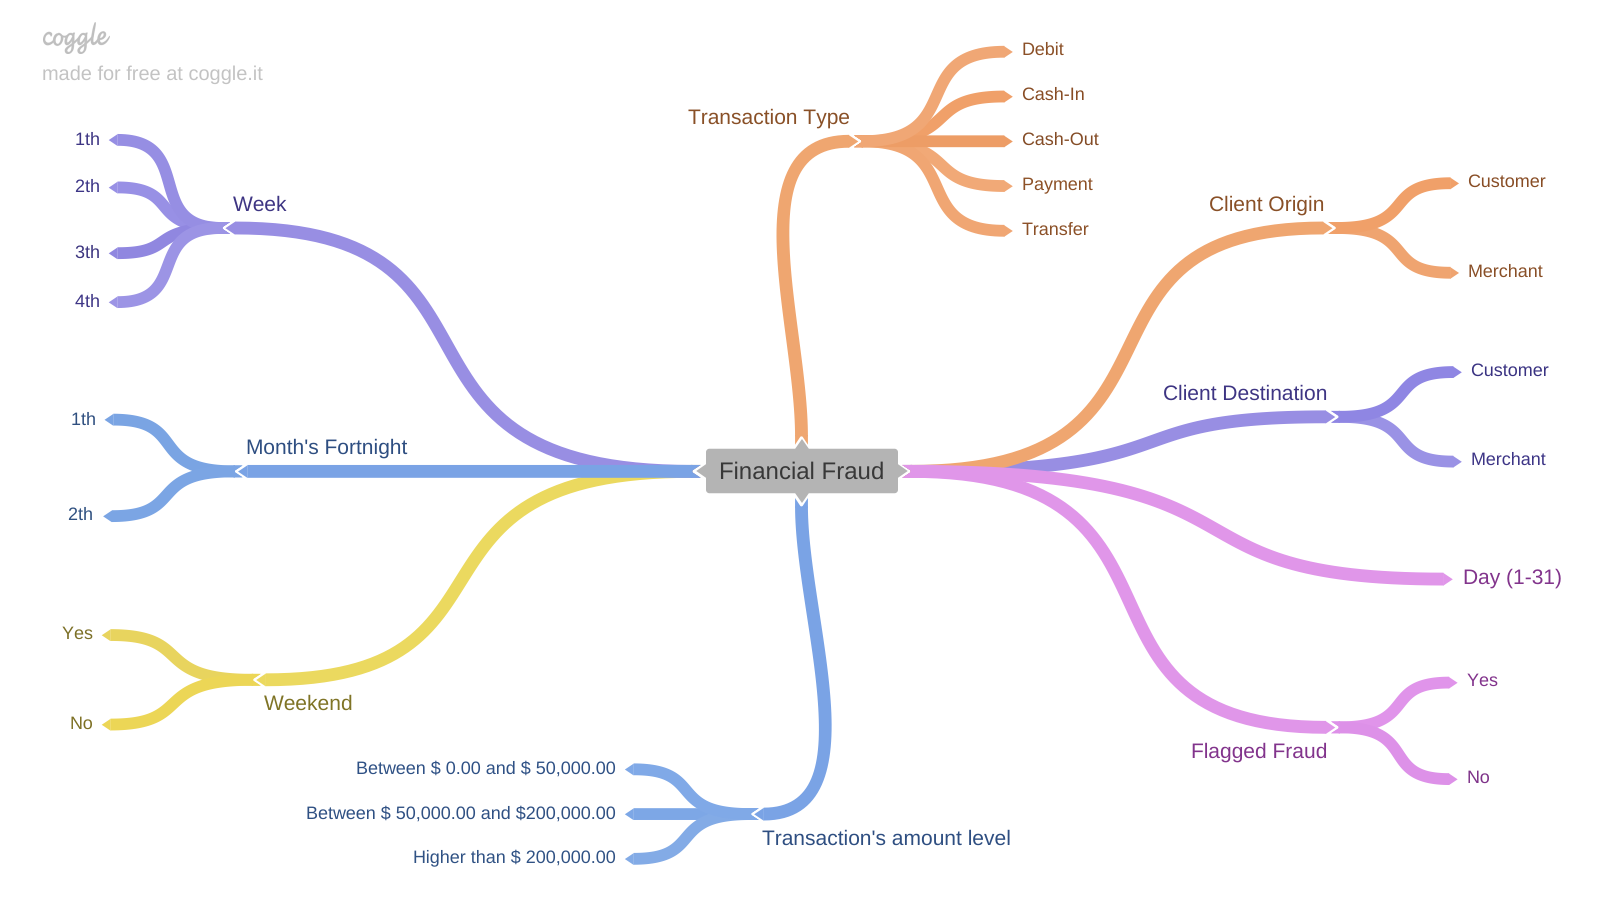

In [13]:
Image('../images/mind_map.png')

***
- **HYPOTESE 1 (H1):** There are more fraudulent transactions in quantity through Cash-Out type

- **HYPOTESE 2 (H2):** There are more fraudulent transactions in total values through Transfer type 

- **HYPOTESE 3 (H3):** All transactions over \$ 200,000.00 are fraudulent

- **HYPOTESE 4 (H4):** Transactions with amount values level between \$ 50,000.00 and \\$ 200,000.00 are more likely to be fraudulent than the others amount levels 

- **HYPOTESE 5 (H5):** Fraudulent transactions happens more to Customer-Customer than Customer-Merchant

- **HYPOTESE 6 (H6):** There is more chance of having a fraudulent transaction when the final origin's balance is zero

- **HYPOTESE 7 (H7):** Fraudulent transactions tends to happen more on the weekends than workweek

- **HYPOTESE 8 (H8):** Fraudulent transactions tends to happen more on the First month's Fortnight than the Second month's Fortnight

## <font color=green size= 5>3.2 FEATURES TRANSFORMATION </font>
***

In [14]:
# creating a dataset's column with the transaction origin account's type
df2['client_orig'] = df2['name_orig'].apply(lambda x: 
                                                     'Merchant' if 'M' in x else
                                                     'Customer')

# creating a dataset's column with the transaction destination account's type
df2['client_dest'] = df2['name_dest'].apply(lambda x: 
                                                     'Merchant' if 'M' in x else
                                                     'Customer')

# creating a dataset's column with the day 
df2['day'] = df2['step'].apply(lambda x: int(x/24 +1))

# creating a dataset's column with the week
df2['week'] = df2['day'].apply(lambda x:
                                         1 if 1 <= x <= 7 else
                                         2 if 8 <= x <= 15 else
                                         3 if 16 <= x <= 23 else
                                         4)

# creating a dataset's column with the fornight 
df2['month_fortnight'] = df2['week'].apply(lambda x:
                                                    0 if 1 <= x <= 2 else
                                                    1)

# creating a dataset's column with the week day type 
df2['weekend'] = df2['day'].apply(lambda x:
                                           1 if x in [6, 7, 13, 14, 20, 21, 27, 28] else
                                           0)

# creating a dataset's column with the transaction amount level
df2['amount_level'] = df2['amount'].apply(lambda x:
                                                    1 if 0 < x <= 50000 else
                                                    2 if 50000 < x < 200000 else
                                                    3)


# creating a dataset's column with the origin account balance error after the transaction
df2['error_balance_orig'] = np.round((df2['new_balance_orig'] + df2['amount'] - df2['old_balance_orig']), 2)

# creating a dataset's column with the destination account balance error after the transaction
df2['error_balance_dest'] = np.round((df2['new_balance_dest'] + df2['amount'] - df2['old_balance_dest']), 2)

# creating a dataset's column with difference (amount) between the old and new origin account balance
df2['flow_orig'] = df2['new_balance_orig'] - df2['old_balance_orig']

# creating a dataset's column with difference (amount) between the old and new destination account balance
df2['flow_dest'] = df2['new_balance_dest'] - df2['old_balance_dest']

In [15]:
# removing the unnecessaries dataset's columns
df2.drop(columns= ['name_orig', 'name_dest'], axis= 1, inplace= True)

# displaying the first 5 dataframe's registers
df2.head()

,step,type,amount,old_balance_orig,new_balance_orig,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,client_orig,client_dest,day,week,month_fortnight,weekend,amount_level,error_balance_orig,error_balance_dest,flow_orig,flow_dest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,Customer,Merchant,1,1,0,0,1,0.0,9839.64,-9839.64,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,Customer,Merchant,1,1,0,0,1,0.0,1864.28,-1864.28,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,Customer,Customer,1,1,0,0,1,0.0,181.00,-181.00,0.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,Customer,Customer,1,1,0,0,1,0.0,-21001.00,-181.00,-21182.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,Customer,Merchant,1,1,0,0,1,0.0,11668.14,-11668.14,0.0


## <font color=green size= 5>3.3 OUTLIERS MANIPULATION </font>
***

**All keypoints pointed at section 2.6 are related to 'amount' column, so we will treat this feature.**

### <font color=green size= 4>3.3.1 TRANSACTIONS AMOUNT'S VALUES OUTLIERS </font>
***

In [16]:
# creating a dataset with only fraudulent transactions from the 'df2' dataset
df2_fraud = df2[df2['is_fraud'] == 1]

# creating a dataset with only non fraudulent transactions from the 'df2' dataset
df2_non_fraud = df2[df2['is_fraud'] == 0]

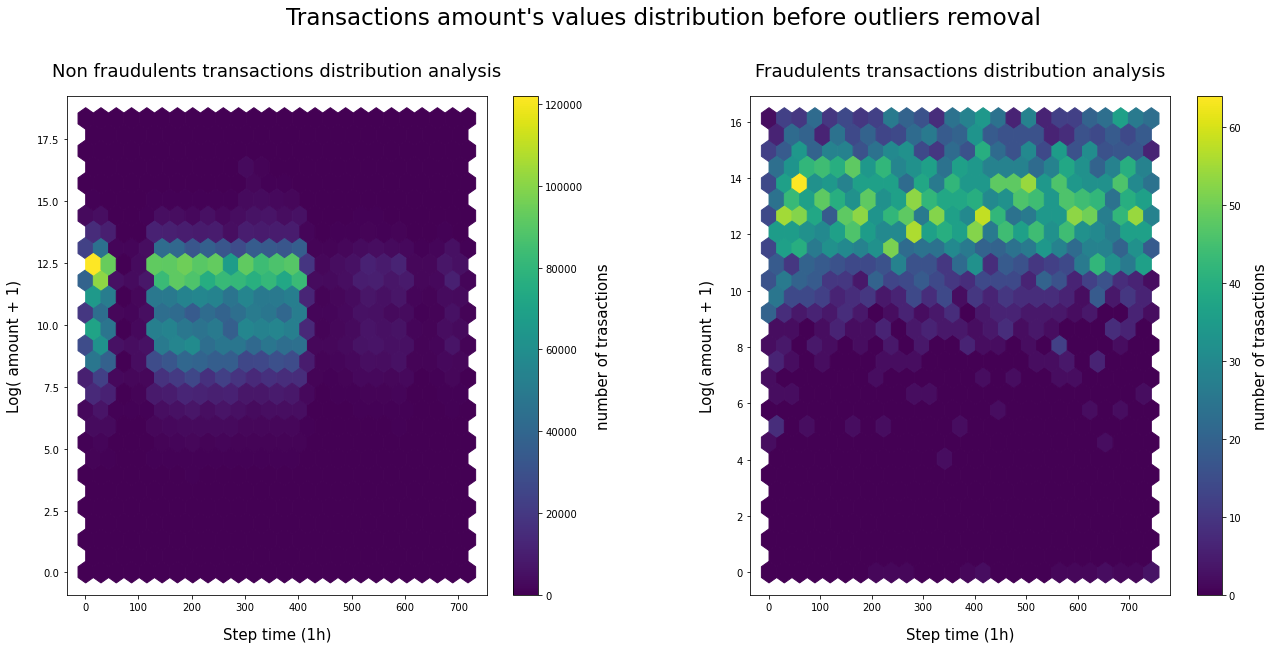

In [17]:
# creating a figure with 2 horizontal axis
fig, axes = plt.subplots(1, 2, figsize= (20, 10))
fig.tight_layout(pad= 10)

# setting the figure title and size
fig.suptitle("Transactions amount's values distribution before outliers removal", size=23)

# setting first axe's graph, title, labels and count bar
graph1= axes[0].hexbin(x= df2_non_fraud['step'], y= np.log1p(df2_non_fraud['amount']), gridsize= 25)
axes[0].set_title("Non fraudulents transactions distribution analysis", size= 18, pad= 20)
axes[0].set_xlabel("Step time (1h)", size= 15, labelpad= 15)
axes[0].set_ylabel("Log( amount + 1)", size= 15, labelpad= 15)
count_bar = plt.colorbar(graph1, ax= axes[0])
count_bar.set_label('number of trasactions', size= 15, labelpad= 12)

# setting second axe's graph, title, labels and count bar
graph2 = axes[1].hexbin(x= df2_fraud['step'], y= np.log1p(df2_fraud['amount']), gridsize= 25)
axes[1].set_title("Fraudulents transactions distribution analysis", size= 18, pad= 20)
axes[1].set_xlabel("Step time (1h)", size= 15, labelpad= 15)
axes[1].set_ylabel("Log( amount + 1)", size= 15, labelpad= 15)
count_bar = plt.colorbar(graph2, ax= axes[1])
count_bar.set_label('number of trasactions', size= 15, labelpad= 12)

# adjusting the spaces between plots
plt.subplots_adjust(wspace= 0.3)

In [18]:
# printing the non fraudulent transaction's outliers range
print('Non fraudulent transactions outliers:')
print(" Any 'step' feature's value between 500 and 700 \n")

# printing the fraudulent transaction's outliers range
print(f'Fraudulent transactions outliers:')
print(f"Any 'amount' feature's value lower than ${round(np.expm1(6), 2)}")

Non fraudulent transactions outliers:
 Any 'step' feature's value between 500 and 700 

Fraudulent transactions outliers:
Any 'amount' feature's value lower than $402.43


In [19]:
# calculating Q1, Q3 and IQR for fraudulent transactions at logarithmic dimensions
fraud_Q1 = np.log1p(np.quantile(df2_fraud['amount'], .25))
fraud_Q3 = np.log1p(np.quantile(df2_fraud['amount'], .75))
fraud_IQR = fraud_Q3 - fraud_Q1

# calculating the fraudulent transactions outliers boundaries through statistical definition at logarithmic dimensions
fraud_low_outliers = fraud_Q1 - 1.5 * fraud_IQR
fraud_high_outliers = fraud_Q3 + 1.5 * fraud_IQR

# returning the outliers values to real values
fraud_low_outliers = np.expm1(fraud_low_outliers)
fraud_high_outliers = np.expm1(fraud_high_outliers)

# calculating Q1, Q3 and IQR for non fraudulent transactions at logarithmic dimensions
non_fraud_Q1 = np.quantile(df2_non_fraud['step'], .25)
non_fraud_Q3 = np.quantile(df2_non_fraud['step'], .75)
non_fraud_IQR = non_fraud_Q3 - non_fraud_Q1

# calculating the non fraudulent transactions outliers boundaries through statistical definition at logarithmic dimensions
non_fraud_low_outliers = non_fraud_Q1 - 1.5 * non_fraud_IQR
non_fraud_high_outliers = non_fraud_Q3 + 1.5 * non_fraud_IQR

In [20]:
# printing the fraudulent transaction's outliers range
print('Fraudulent transactions outliers:')
print(f" Fraudulent transactions outliers by statistical definition: Any 'amount' feature's value higher than ${round(fraud_low_outliers, 2)}")
print(f" Fraudulent transactions outliers by statitstical definition: Any 'amount' feature's value higher than ${round(fraud_high_outliers, 2)} \n")

# printing the non fraudulent transaction's outliers range
print('Non fraudulent transactions outliers:')
print(f" Non fraudulent transactions outliers by statistical definition: Any 'step' feature's value higher than {round(non_fraud_low_outliers, 2)}")
print(f" Non fraudulent transactions outliers by statitstical definition: Any 'step' feature's value higher than {round(non_fraud_high_outliers, 2)}")

Fraudulent transactions outliers:
 Fraudulent transactions outliers by statistical definition: Any 'amount' feature's value higher than $3078.56
 Fraudulent transactions outliers by statitstical definition: Any 'amount' feature's value higher than $62637968.7 

Non fraudulent transactions outliers:
 Non fraudulent transactions outliers by statistical definition: Any 'step' feature's value higher than -111.0
 Non fraudulent transactions outliers by statitstical definition: Any 'step' feature's value higher than 601.0


In [21]:
# removing the fraudulent transactions outliers from 'df2_fraud' dataset
df2_fraud = df2_fraud[~ ((df2_fraud['amount'] > fraud_high_outliers) | (df2_fraud['amount'] < fraud_low_outliers))]

# removing the non fraudulent transactions outliers from 'df2_fraud' dataset
df2_non_fraud = df2_non_fraud[~ ((df2_non_fraud['step'] > non_fraud_high_outliers) | (df2_non_fraud['step'] < non_fraud_low_outliers))]

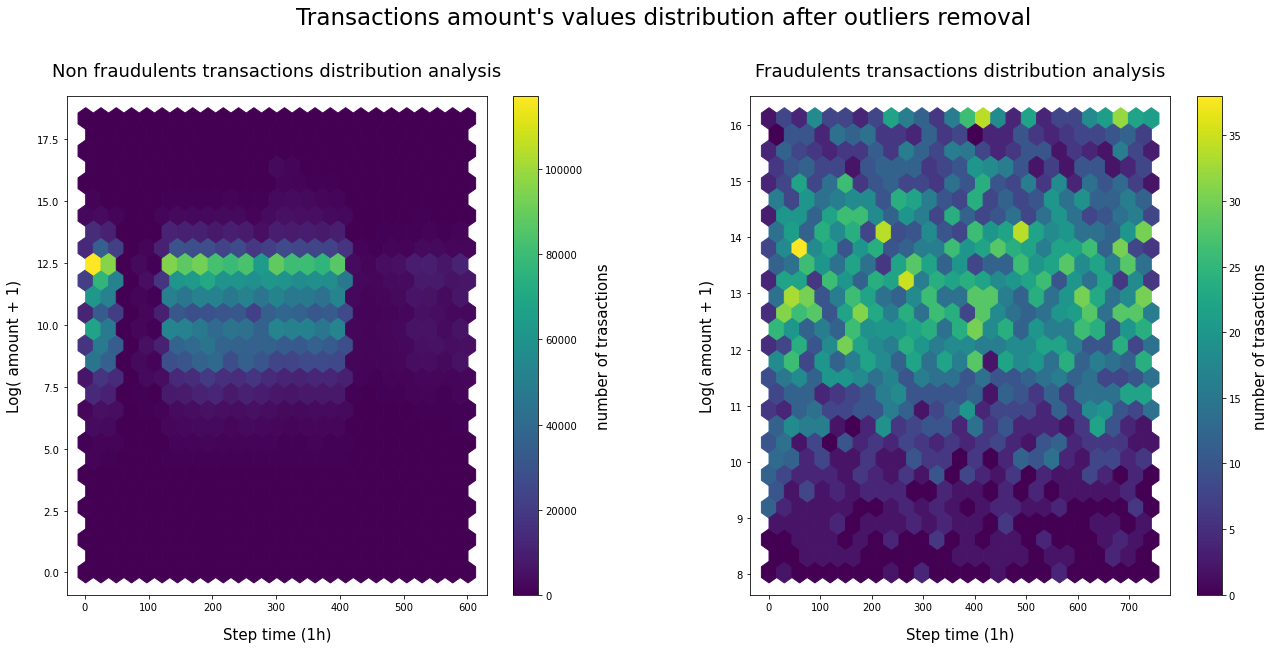

In [22]:
# creating a figure with 2 horizontal axis
fig, axes = plt.subplots(1, 2, figsize= (20, 10))
fig.tight_layout(pad= 10)

# setting the figure title and size
fig.suptitle("Transactions amount's values distribution after outliers removal", size=23)

# setting first axe's graph, title, labels and count bar
graph1= axes[0].hexbin(x= df2_non_fraud['step'], y= np.log1p(df2_non_fraud['amount']), gridsize= 25)
axes[0].set_title("Non fraudulents transactions distribution analysis", size= 18, pad= 20)
axes[0].set_xlabel("Step time (1h)", size= 15, labelpad= 15)
axes[0].set_ylabel("Log( amount + 1)", size= 15, labelpad= 15)
count_bar = plt.colorbar(graph1, ax= axes[0])
count_bar.set_label('number of trasactions', size= 15, labelpad= 12)

# setting second axe's graph, title, labels and count bar
graph2 = axes[1].hexbin(x= df2_fraud['step'], y= np.log1p(df2_fraud['amount']), gridsize= 25)
axes[1].set_title("Fraudulents transactions distribution analysis", size= 18, pad= 20)
axes[1].set_xlabel("Step time (1h)", size= 15, labelpad= 15)
axes[1].set_ylabel("Log( amount + 1)", size= 15, labelpad= 15)
count_bar = plt.colorbar(graph2, ax= axes[1])
count_bar.set_label('number of trasactions', size= 15, labelpad= 12)

# adjusting the spaces between plots
plt.subplots_adjust(wspace= 0.3)

In [23]:
# combining both datasets ('df2_fraud' and 'df2_non_fraud') again
df2 = pd.concat([df2_non_fraud, df2_fraud], axis= 0)

# shuffling the combined dataset, so it don't keep the bias for train and test split method
df2 = shuffle(df2)

# resetting the combined dataset's index
df2.reset_index(drop= True, inplace= True)

# displaying the first 5 dataframe's registers
df2.head()

,step,type,amount,old_balance_orig,new_balance_orig,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,client_orig,client_dest,day,week,month_fortnight,weekend,amount_level,error_balance_orig,error_balance_dest,flow_orig,flow_dest
0,348,PAYMENT,4496.14,0.00,0.00,0.00,0.00,0,0,Customer,Merchant,15,2,0,0,1,4496.14,4496.14,0.00,0.00
1,140,PAYMENT,12428.69,29740.00,17311.31,0.00,0.00,0,0,Customer,Merchant,6,1,0,1,1,0.00,12428.69,-12428.69,0.00
2,329,CASH_IN,259732.81,3324487.24,3584220.05,414024.11,154291.31,0,0,Customer,Customer,14,2,0,1,3,519465.62,0.01,259732.81,-259732.80
3,274,PAYMENT,13640.16,10891.00,0.00,0.00,0.00,0,0,Customer,Merchant,12,2,0,0,1,2749.16,13640.16,-10891.00,0.00
4,10,CASH_IN,198771.68,145.00,198916.68,0.00,421485.08,0,0,Customer,Customer,1,1,0,0,2,397543.36,620256.76,198771.68,421485.08


# <font color=green size= 6> <b>4. EXPLORATORY DATA ANALYSIS </font></b>
***

In [24]:
# creating a dataframe's copy to work, from the original 'df2' dataframe
df3 = df2.copy()

# displaying the first 5 dataframe's registers 
df3.head()

,step,type,amount,old_balance_orig,new_balance_orig,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,client_orig,client_dest,day,week,month_fortnight,weekend,amount_level,error_balance_orig,error_balance_dest,flow_orig,flow_dest
0,348,PAYMENT,4496.14,0.00,0.00,0.00,0.00,0,0,Customer,Merchant,15,2,0,0,1,4496.14,4496.14,0.00,0.00
1,140,PAYMENT,12428.69,29740.00,17311.31,0.00,0.00,0,0,Customer,Merchant,6,1,0,1,1,0.00,12428.69,-12428.69,0.00
2,329,CASH_IN,259732.81,3324487.24,3584220.05,414024.11,154291.31,0,0,Customer,Customer,14,2,0,1,3,519465.62,0.01,259732.81,-259732.80
3,274,PAYMENT,13640.16,10891.00,0.00,0.00,0.00,0,0,Customer,Merchant,12,2,0,0,1,2749.16,13640.16,-10891.00,0.00
4,10,CASH_IN,198771.68,145.00,198916.68,0.00,421485.08,0,0,Customer,Customer,1,1,0,0,2,397543.36,620256.76,198771.68,421485.08


## <font color=green size= 5>4.1 UNIVARIATE ANALYSIS </font>
***

### <font color=green size= 4>4.1.1 CATEGORICAL VARIABLES </font>
***

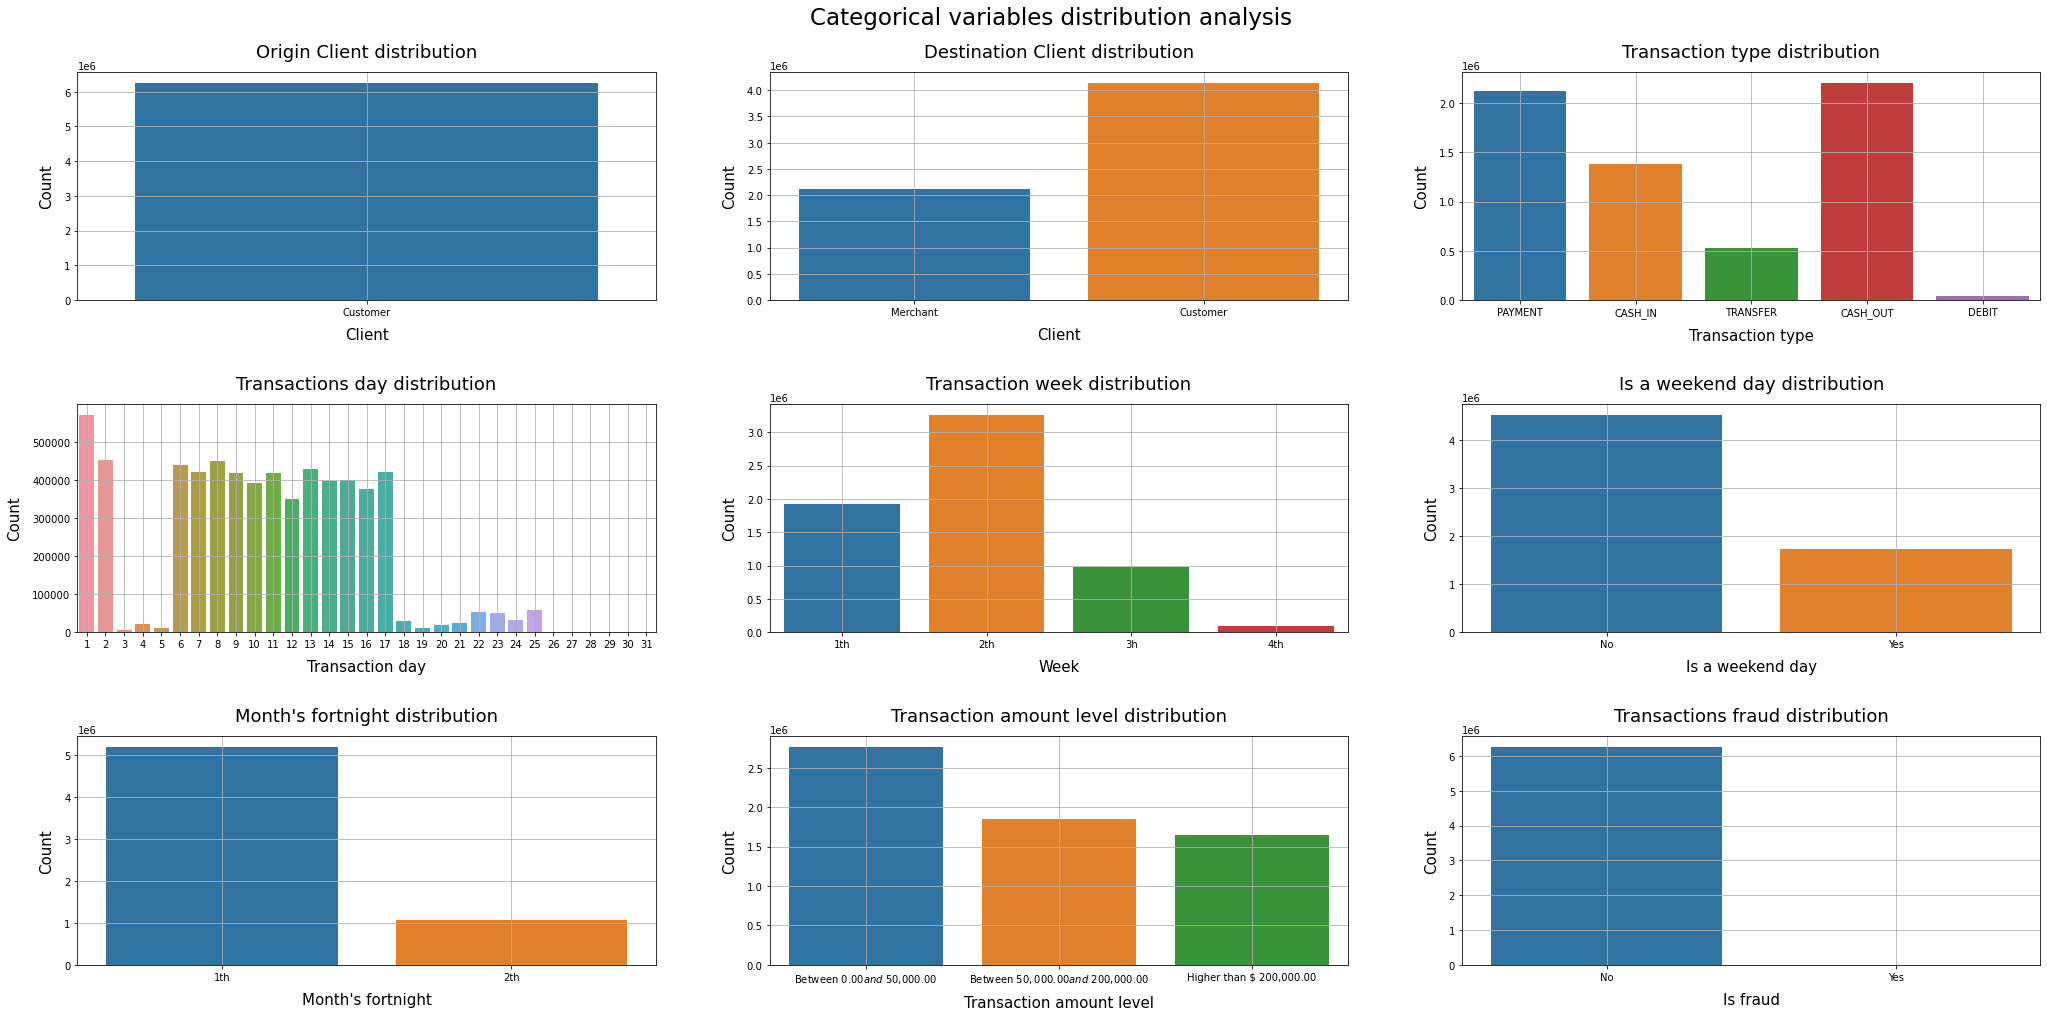

In [25]:
# creating a figure with 3 rows and 3 columns of axes
fig, axes = plt.subplots(3, 3, figsize= (30, 15))
fig.tight_layout(pad= 8.3)

# setting the figure title and size
fig.suptitle('Categorical variables distribution analysis', size=23)

# setting 0,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[0,0], x= df3['client_orig'])
axes[0,0].set_title('Origin Client distribution', size= 18, pad= 15)
axes[0,0].set_xlabel('Client', size= 15, labelpad= 10)
axes[0,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[0,0].grid()

# setting 0,1 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[0,1], x= df3['client_dest'])
axes[0,1].set_title('Destination Client distribution', size= 18, pad= 15)
axes[0,1].set_xlabel('Client', size= 15, labelpad= 10)
axes[0,1].set_ylabel('Count', size= 15, labelpad= 10)
axes[0,1].grid()

# setting 0,2 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[0,2], x= df3['type'])
axes[0,2].set_title('Transaction type distribution', size= 18, pad= 15)
axes[0,2].set_xlabel('Transaction type', size= 15, labelpad= 10)
axes[0,2].set_ylabel('Count', size= 15, labelpad= 10)
axes[0,2].grid()

# setting 1,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[1,0], x= df3['day'])
axes[1,0].set_title('Transactions day distribution', size= 18, pad= 15)
axes[1,0].set_xlabel('Transaction day', size= 15, labelpad= 10)
axes[1,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[1,0].grid()

# setting 1,1 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[1,1], x= df3['week'])
axes[1,1].set_title('Transaction week distribution', size= 18, pad= 15)
axes[1,1].set_xlabel('Week', size= 15, labelpad= 10)
axes[1,1].set_ylabel('Count', size= 15, labelpad= 10)
axes[1,1].set_xticklabels(['1th', '2th', '3h', '4th'])
axes[1,1].grid()

# setting 1,2 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[1,2], x= df3['weekend'])
axes[1,2].set_title("Is a weekend day distribution", size= 18, pad= 15)
axes[1,2].set_xlabel("Is a weekend day", size= 15, labelpad= 10)
axes[1,2].set_ylabel('Count', size= 15, labelpad= 10)
axes[1,2].set_xticklabels(['No', 'Yes'])
axes[1,2].grid()

# setting 2,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[2,0], x= df3['month_fortnight'])
axes[2,0].set_title("Month's fortnight distribution", size= 18, pad= 15)
axes[2,0].set_xlabel("Month's fortnight", size= 15, labelpad= 10)
axes[2,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[2,0].set_xticklabels(['1th', '2th'])
axes[2,0].grid()

# setting 2,1 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[2,1], x= df3['amount_level'])
axes[2,1].set_title('Transaction amount level distribution', size= 18, pad= 15)
axes[2,1].set_xlabel('Transaction amount level', size= 15, labelpad= 10)
axes[2,1].set_ylabel('Count', size= 15, labelpad= 10)
axes[2,1].set_xticklabels(["Between $ 0.00 and $ 50,000.00", "Between $ 50,000.00 and $ 200,000.00", "Higher than $ 200,000.00"])
axes[2,1].grid()

# setting 2,2 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[2,2], x= df3['is_fraud'])
axes[2,2].set_title('Transactions fraud distribution', size= 18, pad= 15)
axes[2,2].set_xlabel('Is fraud', size= 15, labelpad= 10)
axes[2,2].set_ylabel('Count', size= 15, labelpad= 10)
axes[2,2].set_xticklabels(['No', 'Yes'])
axes[2,2].grid()

***
**As seen above:**

- There are no transactions executed by Merchants
- Most of the transactions have account type customer as final destination
- Payment and Cash-Out as the most common type of transactions
- Transactions happens more often between day 6 and 17
- Transactions happens more often in the second month's week
- Transactions happens more during workweeks than weekends
- Transactions happens more often during the first month's fortnight
- There are more transactions with amounts between \$ 0.00 and \\$ 50,000.00 values than other amounts levels
- There is a almost percentage (close to 1%) of transactions which is a fraud, between all transactions executed

### <font color=green size= 4>4.1.2 NUMERICAL VARIABLES </font>
***

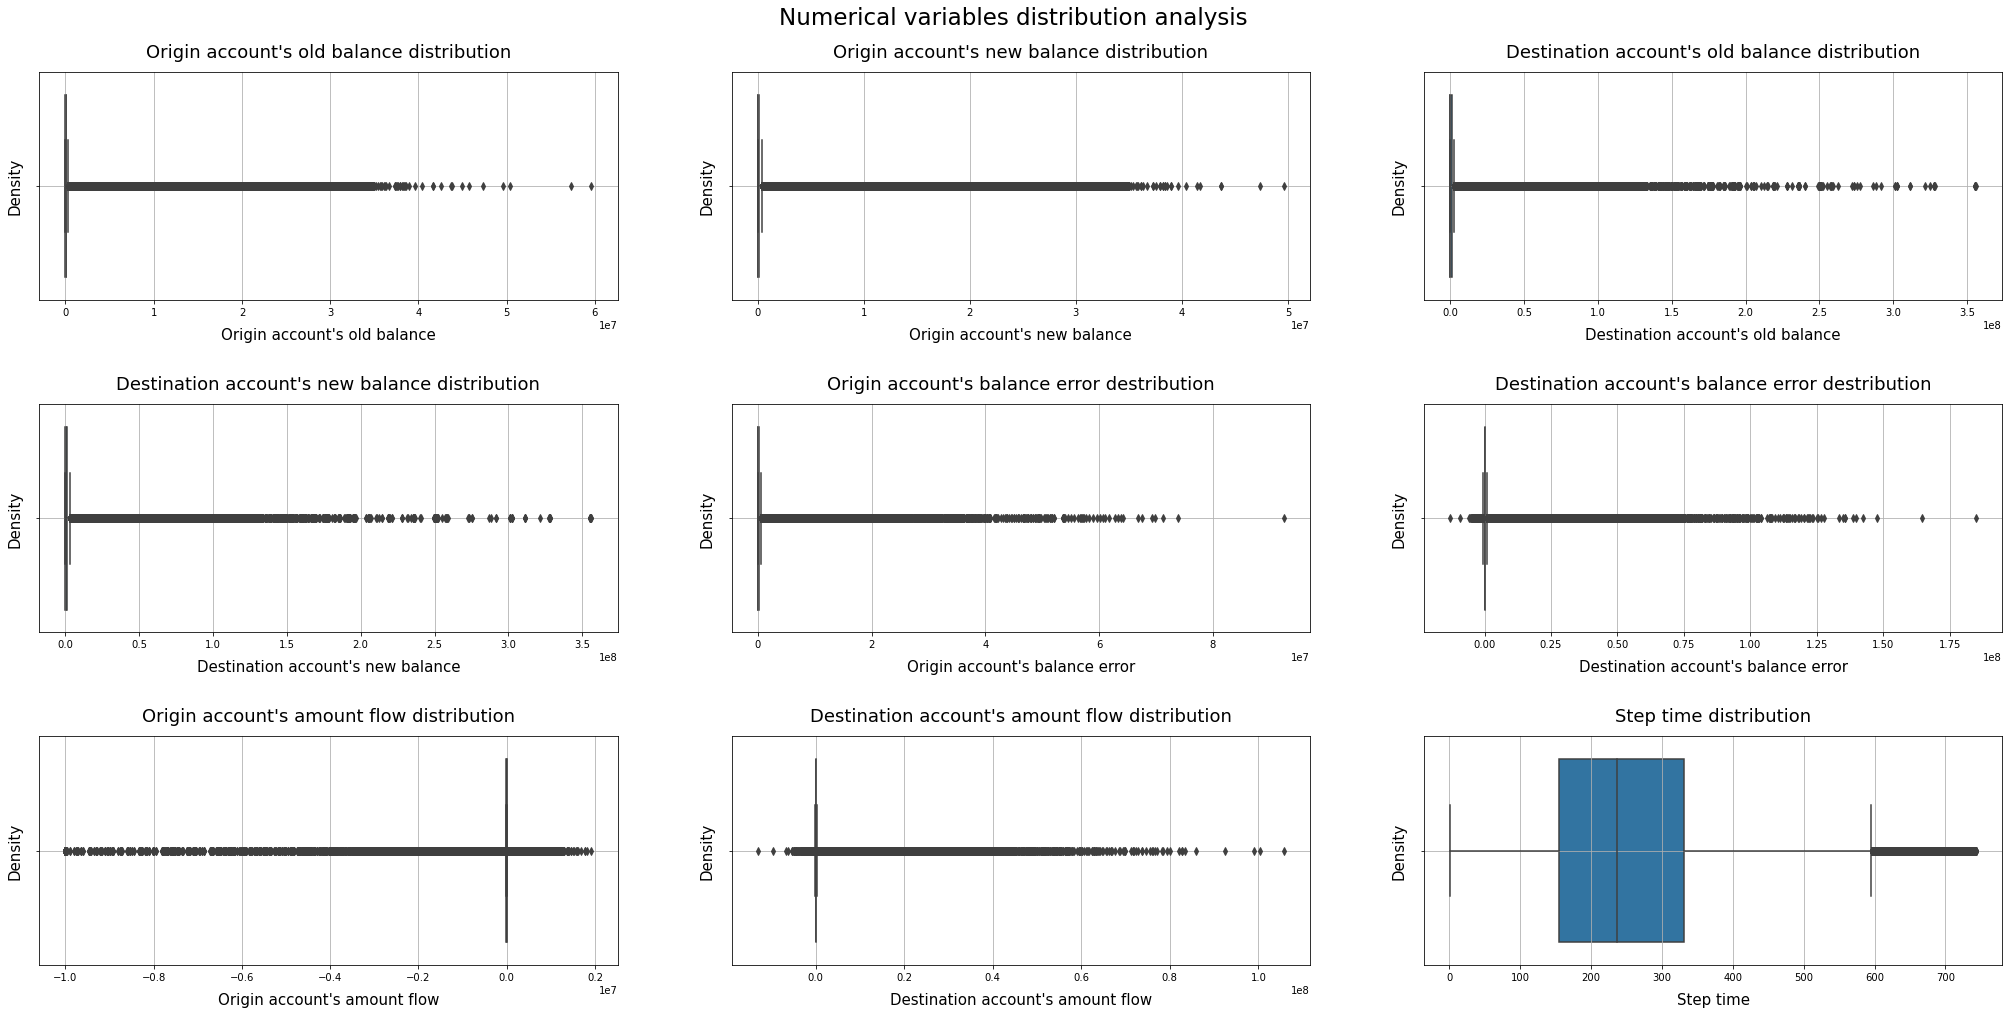

In [26]:
# creating a figure with 2 rows and 3 columns of axes
fig, axes = plt.subplots(3, 3, figsize= (30, 15))
fig.tight_layout(pad=8.3)

# setting the figure title and size
fig.suptitle('Numerical variables distribution analysis', size= 23)

# setting 0,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,0], x= df3['old_balance_orig'])
axes[0,0].set_title("Origin account's old balance distribution", size= 18, pad= 15)
axes[0,0].set_xlabel("Origin account's old balance", size= 15, labelpad= 10)
axes[0,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,0].grid()

# setting 0,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,1], x= df3['new_balance_orig'])
axes[0,1].set_title("Origin account's new balance distribution", size= 18, pad= 15)
axes[0,1].set_xlabel("Origin account's new balance", size= 15, labelpad= 10)
axes[0,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,1].grid()

# setting 0,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,2], x= df3['old_balance_dest'])
axes[0,2].set_title("Destination account's old balance distribution", size= 18, pad= 15)
axes[0,2].set_xlabel("Destination account's old balance", size= 15, labelpad= 10)
axes[0,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,2].grid()

# setting 1,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,0], x= df3['new_balance_dest'])
axes[1,0].set_title("Destination account's new balance distribution", size= 18, pad= 15)
axes[1,0].set_xlabel("Destination account's new balance", size= 15, labelpad= 10)
axes[1,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,0].grid()

# setting 1,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,1], x= df3['error_balance_orig'])
axes[1,1].set_title("Origin account's balance error destribution", size= 18, pad= 15)
axes[1,1].set_xlabel("Origin account's balance error", size= 15, labelpad= 10)
axes[1,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,1].grid()

# setting 1,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,2], x= df3['error_balance_dest'])
axes[1,2].set_title("Destination account's balance error destribution", size= 18, pad= 15)
axes[1,2].set_xlabel("Destination account's balance error", size= 15, labelpad= 10)
axes[1,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,2].grid()

# setting 2,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[2,0], x= df3['flow_orig'])
axes[2,0].set_title("Origin account's amount flow distribution", size= 18, pad= 15)
axes[2,0].set_xlabel("Origin account's amount flow", size= 15, labelpad= 10)
axes[2,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,0].grid()

# setting 2,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[2,1], x= df3['flow_dest'])
axes[2,1].set_title("Destination account's amount flow distribution", size= 18, pad= 15)
axes[2,1].set_xlabel("Destination account's amount flow", size= 15, labelpad= 10)
axes[2,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,1].grid()

# setting 2,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[2,2], x= df3['step'])
axes[2,2].set_title("Step time distribution", size= 18, pad= 15)
axes[2,2].set_xlabel("Step time", size= 15, labelpad= 10)
axes[2,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,2].grid()

***
**As seen above:**

- All numerical variables have a large number of outliers yet, except the 'step' feature

## <font color=green size= 5>4.2 BIVARIATE ANALYSIS </font>
***


### <font color=green size= 4>4.2.1 **HYPOTESE 1 (H1):** There are more fraudulent transactions in quantity through Cash-Out type  </font> - **FALSE**
***

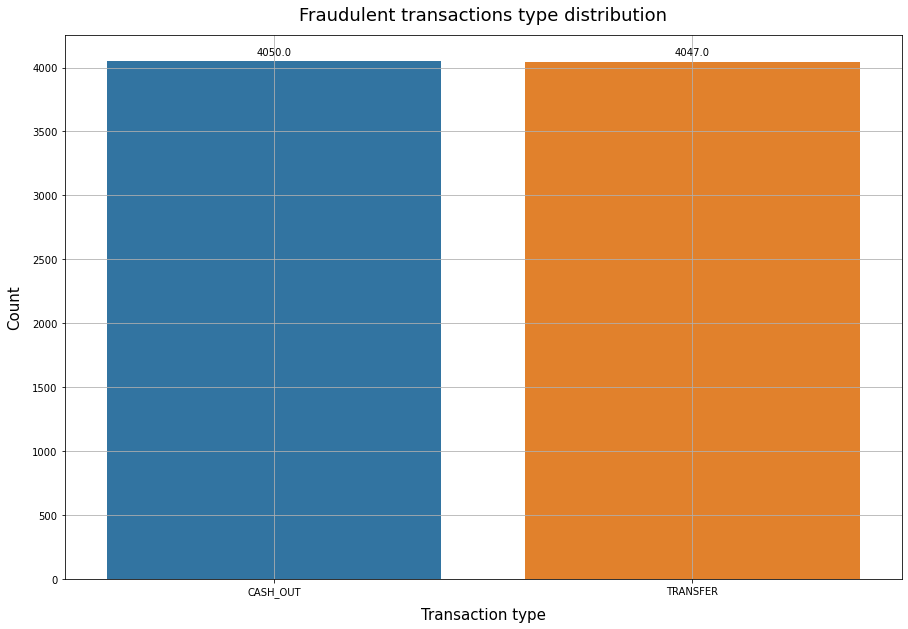

In [27]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxilar dataset
aux = df3[df3['is_fraud'] == 1]

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= aux['type'])
ax.set_title('Fraudulent transactions type distribution', size= 18, pad= 15)
ax.set_xlabel('Transaction type', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H1' in the images folder     
plt.savefig('../images/H1.png')

***
**As seen above:**

- There are just Transfer and Cash-Out type in fraudulent transactions
- The Transfer type is the most common type between both, surpassing with a slightly difference of 3

### <font color=green size= 4>4.2.2 **HYPOTESE 2 (H2):** There are more fraudulent transactions in total values through Transfer type  </font> - **TRUE** 
***

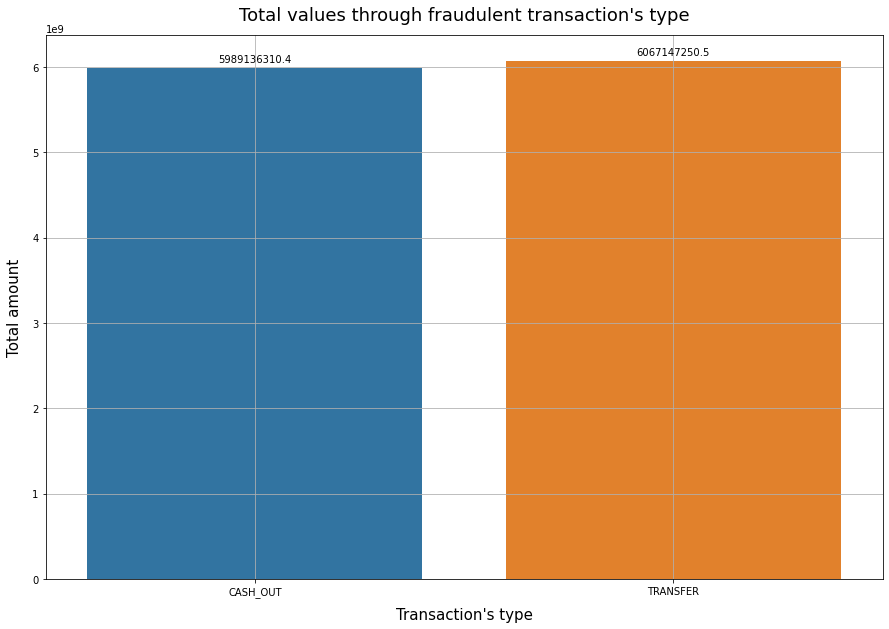

In [28]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxilar dataset
aux = df3[df3['is_fraud'] == 1]

# creating a second auxiliar dataset
aux2 = aux.groupby(by= ['type']).sum()
aux2.reset_index(drop= False, inplace= True)

# setting the graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux2['type'], y= aux2['amount'])
ax.set_title("Total values through fraudulent transaction's type", size= 18, pad= 15)
ax.set_xlabel("Transaction's type", size= 15, labelpad= 10)
ax.set_ylabel('Total amount', size= 15, labelpad= 10)
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H2' in the images folder     
plt.savefig('../images/H2.png')

***
**As seen above:**

Transfer type also have more fraudulent transactions executed in total values then Cash-Out type.

### <font color=green size= 4>4.2.3 **HYPOTESE 3 (H3):** All transactions over $ 200,000.00 are fraudulents </font> - **FALSE** 
***

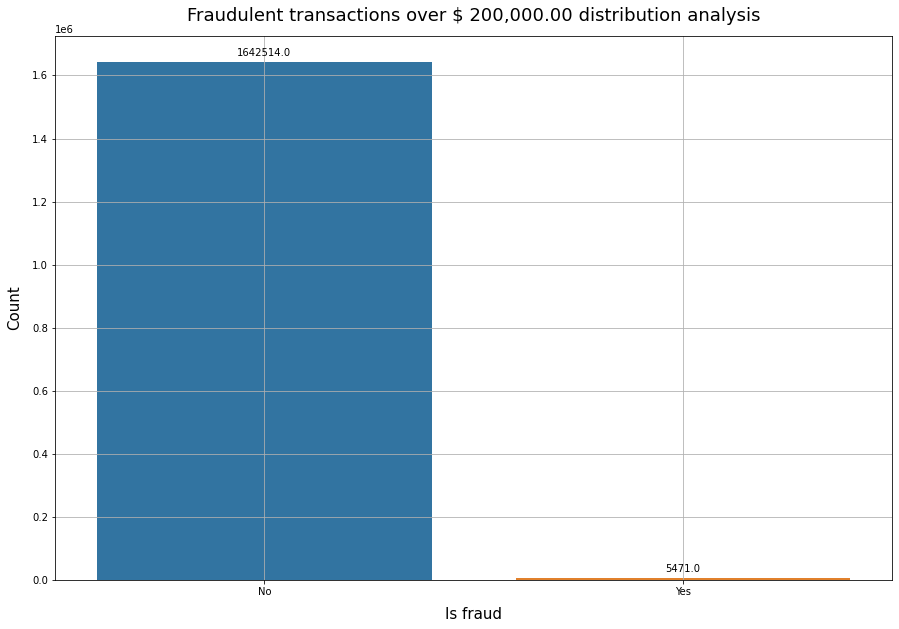

In [29]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxilar dataset
aux = df3[df3['amount'] > 200000]

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= aux['is_fraud'])
ax.set_title('Fraudulent transactions over $ 200,000.00 distribution analysis', size= 18, pad= 15)
ax.set_xlabel('Is fraud', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['No', 'Yes'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H3' in the images folder     
plt.savefig('../images/H3.png')

***
**As seen above:**

- Not all transactions over \$ 200,000.00 are fraudulent
- Only a small percentage of the transactions with \$ 200,000.00 amount or higher are fraudulent

### <font color=green size= 4>4.2.4 **HYPOTESE 4 (H4):** Transactions with amount values level between $ 50,000.00 and 200,000.00 are more likely to be fraudulent than the others amount levels </font> - **FALSE** 
***

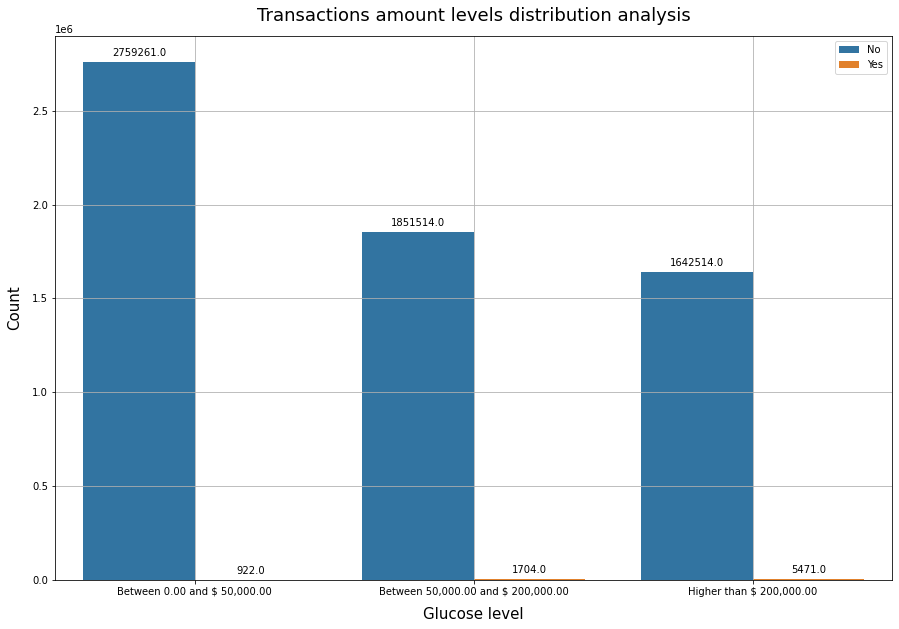

In [30]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxilar numpy array with no/yes values for 'is_fraud' dataframe column
aux = np.where(df3['is_fraud'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['amount_level'], hue= aux)
ax.set_title('Transactions amount levels distribution analysis', size= 18, pad= 15)
ax.set_xlabel('Glucose level', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(["Between 0.00 and $ 50,000.00", "Between 50,000.00 and $ 200,000.00", "Higher than $ 200,000.00"])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H4' in the images folder     
plt.savefig('../images/H4.png')

***
**As seen above:**

- Transaction level between $ 50,000.00 and \\$ 200,000.00 have more fraudulent transactions than between \\$ 0.00 and \\$ 50,000.00 level
- Transaction level with amounts higher than \$ 200,000.00 have more fraudulent transactions of all of them

### <font color=green size= 4>4.2.5 **HYPOTESE 5 (H5):** Fraudulent transations happens more to Customer-Customer than Customer-Merchant relation</font> - **TRUE** 
***

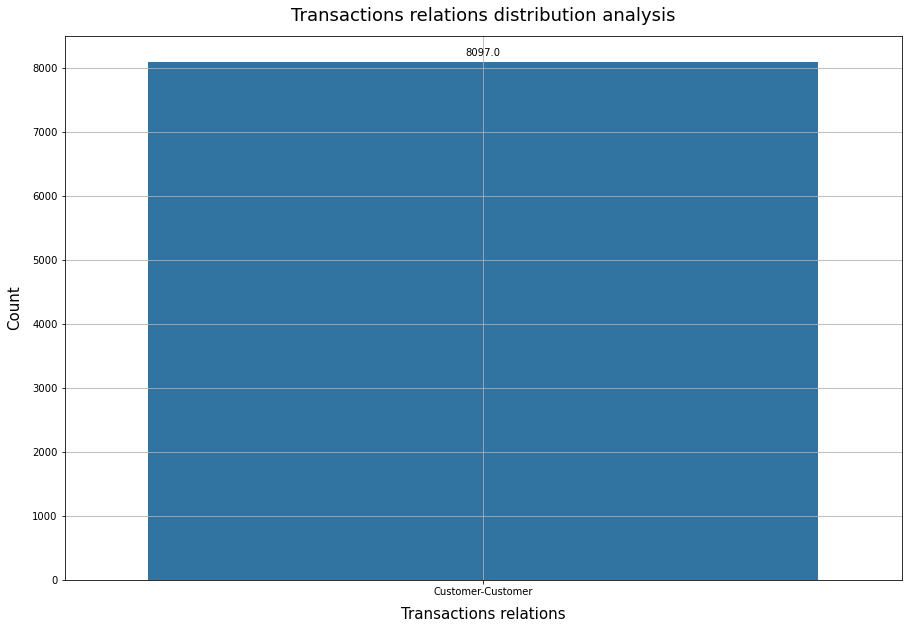

In [31]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxilar dataset
aux = df3[(df3['is_fraud'] == 1) & (df3['client_orig'] == 'Customer')]

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= aux['client_dest'])
ax.set_title('Transactions relations distribution analysis', size= 18, pad= 15)
ax.set_xlabel('Transactions relations', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Customer-Customer'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H5' in the images folder     
plt.savefig('../images/H5.png')

***
**As seen above:**

There are only fraudulent transactions between Customer-Customer relation.

### <font color=green size= 4>4.2.6 **HYPOTESE 6 (H6):** There is more chance of having a fraudulent transaction when the final origin's balance is zero </font> - **TRUE** 
***

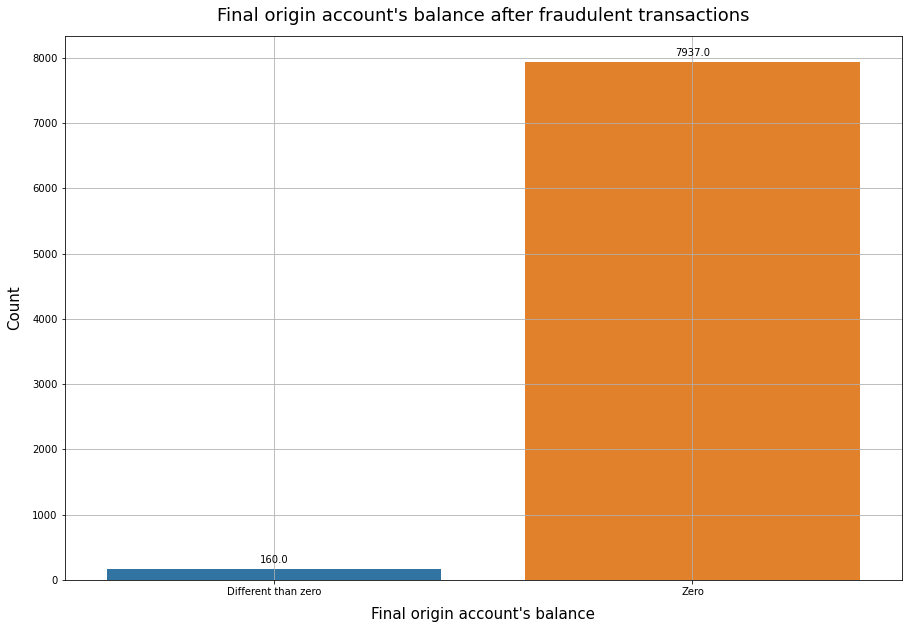

In [32]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxiliar dataset
aux = df3[df3['is_fraud'] == 1]
aux.reset_index(drop= False, inplace= True)

# creating 'final_balance_orig' column at the auxilar dataset
aux['final_balance_orig'] = np.where(aux['new_balance_orig'] == 0, 1, 0)

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= aux['final_balance_orig'])
ax.set_title("Final origin account's balance after fraudulent transactions", size= 18, pad= 15)
ax.set_xlabel("Final origin account's balance", size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Different than zero', 'Zero'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H6' in the images folder     
plt.savefig('../images/H6.png')

***
**As seen above:**

Only a few percent of the fraudulent transactions leave the origin account's final balance with values different than zero.

### <font color=green size= 4>4.2.7 **HYPOTESE 7 (H7):** Fraudulent transactions tends to happen more on the weekends than workweek </font> - **FALSE** 
***

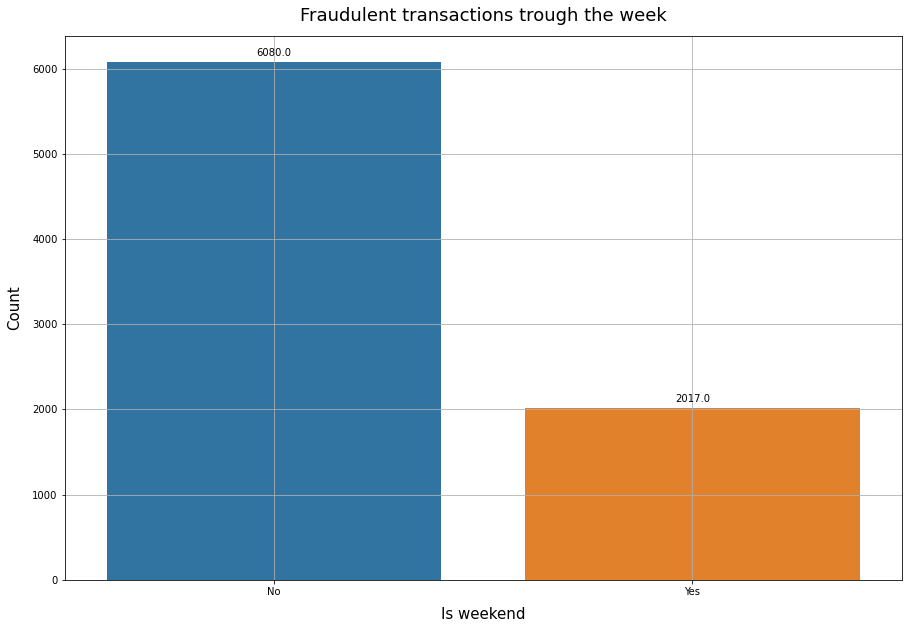

In [33]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxiliar dataset
aux = df3[df3['is_fraud'] == 1]
aux.reset_index(drop= False, inplace= True)

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= aux['weekend'])
ax.set_title("Fraudulent transactions trough the week", size= 18, pad= 15)
ax.set_xlabel("Is weekend", size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['No', 'Yes'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H7' in the images folder     
plt.savefig('../images/H7.png')

***
**As seen above:**

Fraudulent transactions are more likely to happen during the workweek than weekends.

### <font color=green size= 4>4.2.8 **HYPOTESE 8 (H8):** Fraudulent transactions tends to happen more on the First month's Fortnight than the Second month's Fortnight</font> - **FALSE** 
***

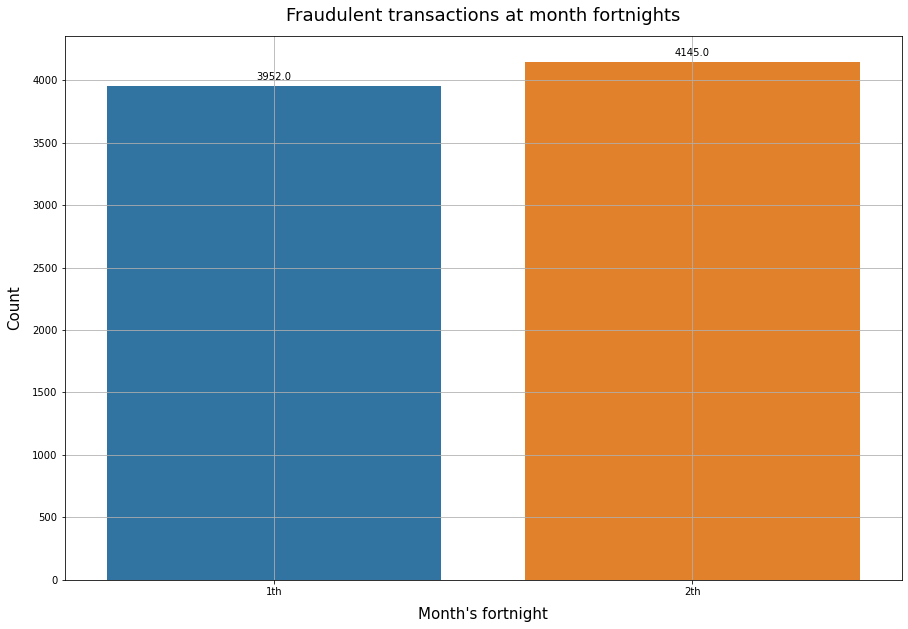

In [34]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating an auxiliar dataset
aux = df3[df3['is_fraud'] == 1]
aux.reset_index(drop= False, inplace= True)

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= aux['month_fortnight'])
ax.set_title("Fraudulent transactions at month fortnights", size= 18, pad= 15)
ax.set_xlabel("Month's fortnight", size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['1th', '2th'])
ax.grid()

# setting values annotate for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H8' in the images folder     
plt.savefig('../images/H8.png')

***
**As seen above:**

Despite the fact that transactions are more likely to happen at the first month's fortnight, the fraudulent transactions are more likely to happen, with a slightly difference, at the second month's fortnight.

## <font color=green size= 5>4.3 MULTIVARIATE ANALYSIS </font>
***

<AxesSubplot:>

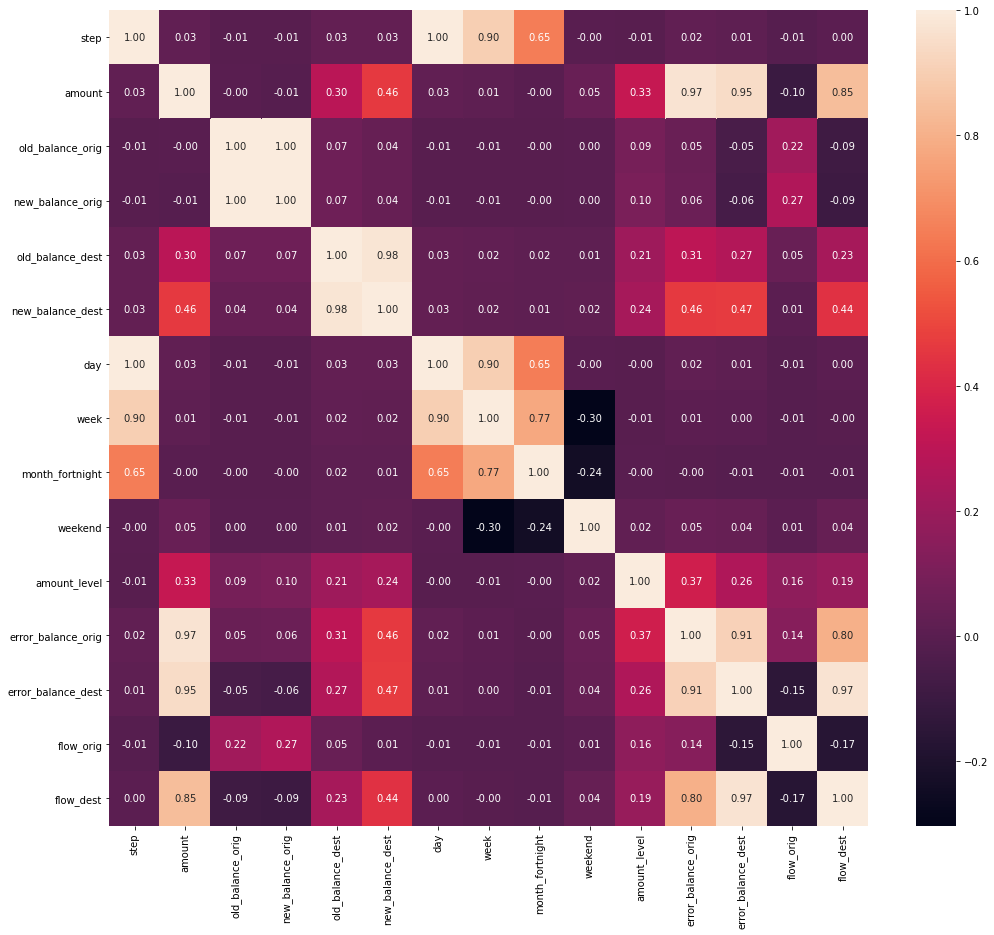

In [35]:
# creating a dataset with only the numerical values from 'df3' dataset
df3_num = df3.select_dtypes(include= ['float64', 'int64'])

# drop the 'is_fraud' and 'is_flagged_fraud' columns, which we are not interesed now
df3_num.drop(columns = ['is_fraud', 'is_flagged_fraud'], axis= 1, inplace= True)

# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (17, 15))

# creating a correlation matrix from 'df3_num' dataframe
corre = df3_num.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre' as data
ax = sns.heatmap(corre, annot = True, fmt= '.2f')

# plotting the heat map
ax;

***
**As seen above:**

There are some variables that have a strong correlation between them.

This correlation isn't good for the model, because it increases the dimensionality without a considerable variance. So in this case, we should remove one of them, and that's what we gonna do.
<br>

**In this case, there are a few correlated variables, which are:**

- 'step'                and   'day'                  (100% correlation)
- 'new_balance_orig'    and   'old_balance_orig'     (100% correlation)
- 'new_balance_dest'    and   'old_balance_dest'      (98% correlation) 
- 'error_balance_dest'  and   'flow_dest'             (97% correlation)
- 'error_balance_orig'  and   'amount'                (97% correlation)
- 'error_balance_dest'  and   'amount'                (95% correlation)
- 'step'                and   'week'                  (90% correlation)
<br>
<br>

**In this situation we are gonna exclude the following variables:**

- 'day'
- 'old_balance_dest'
- 'old_balance_orig'
- 'error_balance_dest'
- 'week'
- 'error_balance_orig'

In [36]:
# deleting the unecessary variables from the 'df3' dataset
df3.drop(columns= ['day', 'old_balance_dest', 'old_balance_orig', 'error_balance_dest', 'week', 'error_balance_orig'], inplace= True)

<AxesSubplot:>

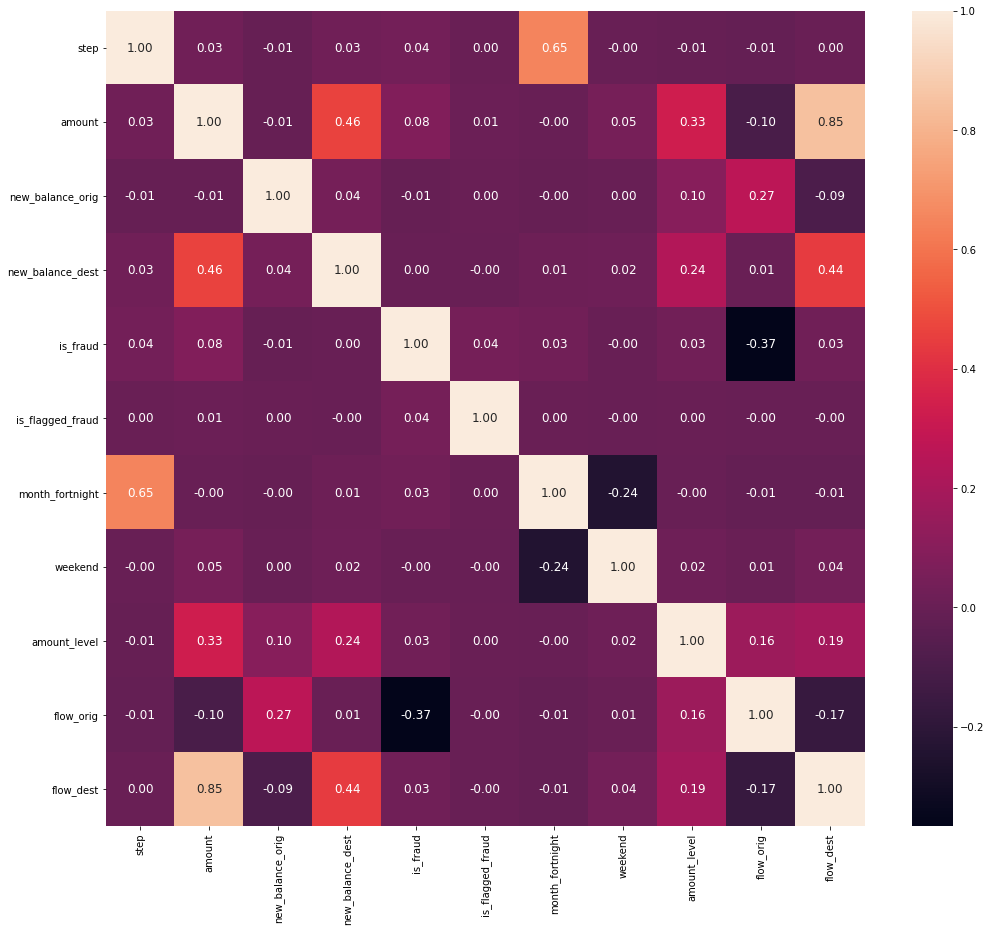

In [37]:
# creating a dataset with only the numerical values from 'df3' dataset
df3_num = df3.select_dtypes(include= ['float64', 'int64'])

# creating a correlation matrix from 'df3_num' dataset
corre = df3_num.corr()

# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (17, 15))

# creating a heatmap graph using the correlation matrix 'corre' as data
ax= sns.heatmap(corre, annot= True, fmt= ".2f", annot_kws= {"size":12})

# plotting the heat map
ax;

***
**As seen above:** 
<br>

**There are some variables that have considerable impact over 'is_fraud' result values:**

- 'amount'
- 'step'
- 'moth_fortnight'
- 'amount_level'
- 'flow_dest'
- 'is_flagged_fraud'

# <font color=green size= 6> <b>5. DATA PREPARATION </font></b>
***

In [38]:
# creating a dataframe's copy to work, from the original 'df3' dataframe
df4 = df3.copy()

# displaying the first 5 dataframe's registers 
df4.head()

,step,type,amount,new_balance_orig,new_balance_dest,is_fraud,is_flagged_fraud,client_orig,client_dest,month_fortnight,weekend,amount_level,flow_orig,flow_dest
0,348,PAYMENT,4496.14,0.00,0.00,0,0,Customer,Merchant,0,0,1,0.00,0.00
1,140,PAYMENT,12428.69,17311.31,0.00,0,0,Customer,Merchant,0,1,1,-12428.69,0.00
2,329,CASH_IN,259732.81,3584220.05,154291.31,0,0,Customer,Customer,0,1,3,259732.81,-259732.80
3,274,PAYMENT,13640.16,0.00,0.00,0,0,Customer,Merchant,0,0,1,-10891.00,0.00
4,10,CASH_IN,198771.68,198916.68,421485.08,0,0,Customer,Customer,0,0,2,198771.68,421485.08


## <font color=green size= 5>5.1 SAMPLING THE DATASET </font>
***

**We need to sample the dataset, because of our processor capacity.**

In [39]:
# checking the answer classes proportion
df4['is_fraud'].value_counts(normalize= True)

0    0.998707
1    0.001293
Name: is_fraud, dtype: float64

In [40]:
# sampling 1/6 of the 'df4' dataset registers with answer class 0
df4_sample_legitimate = df4[df4['is_fraud'] == 0].sample(1000000)

# segregate the dataset registers with all answer class 1
df4_sample_fraud = df4[df4['is_fraud'] == 1]

# combining both datasets
df4_sample = pd.concat([df4_sample_legitimate, df4_sample_fraud], axis= 0)

# resetting the sample dataset index
df4_sample.reset_index(drop= True, inplace= True)

In [41]:
# checking the answer classes proportion in the sample dataset
df4_sample['is_fraud'].value_counts(normalize= True)

0    0.991968
1    0.008032
Name: is_fraud, dtype: float64

***
**As seen above:**
- Both datasets answer's classes proportions seems to be approximately the same. So we kept the dataset bias

In [42]:
# shuffling the sample dataset, so it don't keep the bias for train and test split method
df4_sample = shuffle(df4_sample)

# resetting the dataset index
df4_sample.reset_index(drop= True, inplace= True)

# defining 'df4' dataset again as the sample dataset created
df4 = df4_sample

## <font color=green size= 5>5.2 RESCALE AND NORMALIZE NUMERICAL FEATURES </font>
***

In the section we will executed the numerical variables rescaling and normalization. For this, these variables outliers must be known, to choose the best method to be applied.

**The techniques that will be used:**

- **RobustScaler:** Robust in the presence of outliers, will be applied at variables that have a significant amount of outliers 

- **MinMaxScaler:** Sensitive in the presence of outliers, will be applied at variables that have a significant amount of outliers 

As seen on section 4.1.2, all numerical variables have significant amount of outliers, even with some outliers removal (on section 3.3), except the 'step' variable.

In [43]:
# instantiating MinMaxScaler method as 'mms'
mms = MinMaxScaler()

# instantiating RobustScaler method as 'rs'
rs = RobustScaler()


# rescaling the dataset's 'step' feature 
df4['step'] = mms.fit_transform(df4[['step']].values)

# saving the 'step' feature rescaling method
pickle.dump(mms, open('../parameters/step_scaler.pkl', 'wb'))



# rescaling the dataset's 'amount' feature       
df4['amount'] = rs.fit_transform(df4[['amount']].values)

# saving the 'amount' feature rescaling method
pickle.dump(rs, open('../parameters/amount_scaler.pkl', 'wb'))



# rescaling the dataset's 'new_balance_orig' feature 
df4['new_balance_orig'] = rs.fit_transform(df4[['new_balance_orig']].values)

# saving the 'new_balance_orig' feature rescaling method
pickle.dump(rs, open('../parameters/new_balance_orig_scaler.pkl', 'wb'))



# rescaling the dataset's 'new_balance_dest' feature 
df4['new_balance_dest'] = rs.fit_transform(df4[['new_balance_dest']].values)

# saving the 'new_balance_dest' feature rescaling method
pickle.dump(rs, open('../parameters/new_balance_dest_scaler.pkl', 'wb'))



# rescaling the dataset's 'flow_orig' feature  
df4['flow_orig'] = rs.fit_transform(df4[['flow_orig']].values)

# saving the 'flow_orig' feature rescaling method
pickle.dump(rs, open('../parameters/flow_orig_scaler.pkl', 'wb'))



# rescaling the dataset's 'flow_dest' feature           
df4['flow_dest'] = rs.fit_transform(df4[['flow_dest']].values)

# saving the 'flow_dest' feature rescaling method
pickle.dump(rs, open('../parameters/flow_dest_scaler.pkl', 'wb'))

## <font color=green size= 5>5.3 ENCODE CATEGORICAL FEATURES </font>
***

### <font color=green size= 4>5.3.1 BINARY CATEGORICAL FEATURES </font>
***

In [44]:
# creating a dictonary to replace the client type to a numeral representative
client_num = {'Customer': 1, 'Merchant': 0}

# transforming binary categorical's variables
df4['client_orig'] = df4['client_orig'].map(client_num)
df4['client_dest'] = df4['client_dest'].map(client_num)

### <font color=green size= 4>5.3.2 NON-BINARY CATEGORICAL FEATURES</font>
***

In [45]:
# creating a dictonary to replace the transaction amount level to a string representative
amount_level_str = {1: 'between_0_50', 2: 'between_50_200', 3: 'over_200'}

# transforming the non-binary categorical's variables
df4['amount_level'] = df4['amount_level'].map(amount_level_str)

In [46]:
# instantiating the OneHotEncoder method as 'ohe'
ohe = OneHotEncoder(cols= ['type'], use_cat_names= True)

# transforming the 'df4' dataset with the 'ohe' method
df4 = ohe.fit_transform(df4)

# saving the OneHotEncoder trained method
pickle.dump(ohe, open('../parameters/onehotencoder_type.pkl', 'wb'))

# renaming the columns created by the OneHotEncoder method
df4.rename(columns = {'type_CASH_OUT': 'cash_out', 
                           'type_PAYMENT': 'payment', 
                           'type_CASH_IN': 'cash_in', 
                           'type_TRANSFER': 'transfer',
                           'type_DEBIT': 'debit'}, inplace= True)



# instantiating the OneHotEncoder method as 'ohe'
ohe = OneHotEncoder(cols= ['amount_level'], use_cat_names= True)

# transforming the 'df4' dataset with the 'ohe' method
df4 = ohe.fit_transform(df4)

# saving the OneHotEncoder trained method
pickle.dump(ohe, open('../parameters/onehotencoder_amount_level.pkl', 'wb'))

# renaming the columns created by the OneHotEncoder method
df4.rename(columns = {'amount_level_between_0_50': 'between_0_50', 
                           'amount_level_between_50_200': 'between_50_200', 
                           'amount_level_over_200': 'over_200'}, inplace= True)


# displaying the first 5 dataframe's registers
df4.head()

,step,cash_out,cash_in,transfer,payment,debit,amount,new_balance_orig,new_balance_dest,is_fraud,is_flagged_fraud,client_orig,client_dest,month_fortnight,weekend,between_50_200,over_200,between_0_50,flow_orig,flow_dest
0,0.021563,1,0,0,0,0,-0.020535,0.000000,-0.127147,0,0,1,1,0,0,1,0,0,-5.348921,0.477938
1,0.179245,1,0,0,0,0,-0.010514,0.000000,1.229882,0,0,1,1,0,1,1,0,0,-1.103152,0.491127
2,0.206199,0,1,0,0,0,1.442107,2.581613,-0.191647,0,0,1,1,0,1,0,1,0,34.752019,-0.666399
3,0.277628,0,0,1,0,0,0.626007,0.000000,0.898117,0,0,1,1,0,0,1,0,0,0.000000,1.328912
4,0.699461,1,0,0,0,0,0.530410,0.000000,0.154457,0,0,1,1,1,0,1,0,0,0.000000,1.203088


# <font color=green size= 6> <b>6. FEATURE SELECTION </font></b>
***

In [47]:
# creating a dataframe's copy to work, from the original 'df4' dataframe
df5 = df4.copy()

# displaying the first 5 dataframe's registers 
df5.head()

,step,cash_out,cash_in,transfer,payment,debit,amount,new_balance_orig,new_balance_dest,is_fraud,is_flagged_fraud,client_orig,client_dest,month_fortnight,weekend,between_50_200,over_200,between_0_50,flow_orig,flow_dest
0,0.021563,1,0,0,0,0,-0.020535,0.000000,-0.127147,0,0,1,1,0,0,1,0,0,-5.348921,0.477938
1,0.179245,1,0,0,0,0,-0.010514,0.000000,1.229882,0,0,1,1,0,1,1,0,0,-1.103152,0.491127
2,0.206199,0,1,0,0,0,1.442107,2.581613,-0.191647,0,0,1,1,0,1,0,1,0,34.752019,-0.666399
3,0.277628,0,0,1,0,0,0.626007,0.000000,0.898117,0,0,1,1,0,0,1,0,0,0.000000,1.328912
4,0.699461,1,0,0,0,0,0.530410,0.000000,0.154457,0,0,1,1,1,0,1,0,0,0.000000,1.203088


## <font color=green size= 5>6.1 BORUTA BEST FEATURES SELECTION </font>
***

**Boruta library:** <a href="https://pypi.org/project/Boruta/">Here</a></font>

In [48]:
# defining model that will be checked by the boruta method
rf_model = RandomForestClassifier(n_jobs = -1)

# defining the train arrays
x_train_boruta = df5.drop(columns= ['is_fraud']).values
y_train_boruta = df5['is_fraud'].values.ravel()

# instantiating the boruta method
boruta = BorutaPy(rf_model, n_estimators= 'auto', verbose= 2)

# training the boruta method
boruta.fit(x_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	11


BorutaPy(estimator=RandomForestClassifier(n_estimators=61, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x29E2148A640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x29E2148A640, verbose=2)

In [53]:
# instantiating the dataset selected columns by the boruta method
cols = boruta.support_.tolist()
boruta_selected_features = df5.drop(columns= ['is_fraud']).iloc[:, cols].columns.to_list()

# displaying the selected features by boruta
print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['step',
 'cash_out',
 'transfer',
 'amount',
 'new_balance_orig',
 'new_balance_dest',
 'flow_orig',
 'flow_dest']

## <font color=green size= 5>6.2 RANDOM FOREST BEST FEATURES SELECTION </font>
***

Random forest features importance:


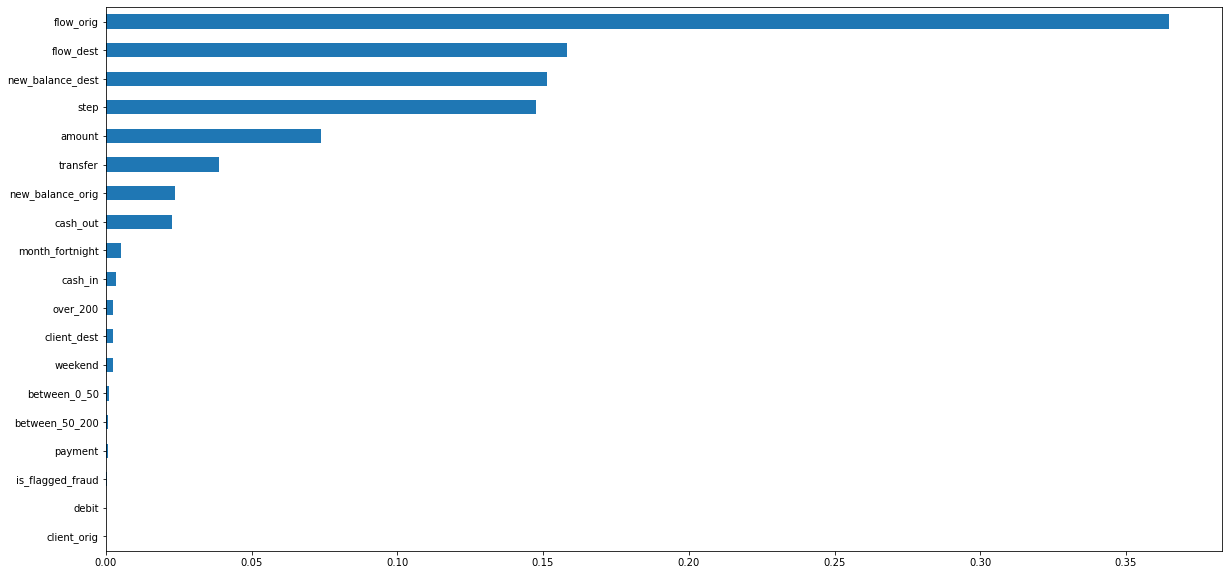

In [56]:
# define random forest model
rf_model = RandomForestClassifier(n_jobs= -1)

# define the train arrays
x_train_rfc = df5.drop(columns= ['is_fraud'])
y_train_rfc = df5['is_fraud']

# train the random forest model
rf_model.fit(x_train_rfc, y_train_rfc)

# create a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (20, 10))

# create a series and plot the model's features importance
feat_importances = pd.Series(rf_model.feature_importances_, index= x_train_rfc.columns)
print('Random forest features importance:')
feat_importances.sort_values().plot(kind= 'barh');

## <font color=green size= 5>6.3 RECURSIVE FEATURE ELIMINATION (RFE) BEST FEATURES SELECTION </font>
***

In [57]:
# defining random forest model
rf = RandomForestClassifier(n_jobs= -1)

# defining the train arrays
x_train_rfe = df5.drop(columns= ['is_fraud'])
y_train_rfe = df5['is_fraud']

# defining the amount of features to select
rfe_selector = RFE(rf, n_features_to_select= 10, step= 1)

# training the model
rfe_selector = rfe_selector.fit(x_train_rfe, y_train_rfe)

# ranking the beast features
selected_features_T_F = rfe_selector.support_.tolist()

# getting the selected features columns names
features_columns = x_train_rfe.columns

# instantiating an empty list
rfe_selected_features = []

# inserting the selected columns into the empty list
for binary, feature in zip(selected_features_T_F, features_columns):
    if binary == True:
        rfe_selected_features.append(feature)

# displaying the selected features by RFE
print('RFE selected features:')
rfe_selected_features

RFE selected features:


['step',
 'cash_out',
 'transfer',
 'amount',
 'new_balance_orig',
 'new_balance_dest',
 'month_fortnight',
 'over_200',
 'flow_orig',
 'flow_dest']

## <font color=green size= 5>6.4 MANUAL BEST FEATURES SELECTION </font>
***

In [58]:
# creating a list with only the selected variables by analising the selected features by the methods above
manual_selected_features = ['step',
                     'amount',
                     'new_balance_orig',
                     'new_balance_dest',
                     'flow_orig',
                     'flow_dest',
                     'transfer',
                     'cash_out',
                     'weekend']

# inserting the 'is_fraud'/answer column at the manual selected features list
manual_selected_features.append('is_fraud')

# filtering the dataset with only the manual selected columns and the answer column
df5 = df5[manual_selected_features]

# removing 'is_fraud'/answer column from the manual selected features list
manual_selected_features.pop()

'is_fraud'

## <font color=green size= 5>6.5 SPLIT TRAIN & TEST DATASET </font>
***

In [59]:
# creating the 'features' dataset by removing the 'is_fraud'/aswer column
features = df5.drop(columns= ['is_fraud'])

# creating the 'labels' dataset by filtering only the 'is_fraud'/aswer column
labels = df5['is_fraud']

# creating train and test features and labels datasets / series
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state= 301, test_size= 0.25, stratify= labels)

## <font color=green size= 5>6.6 RESAMPLING SELECTION </font>
***

In [60]:
# instantiating the 'SMOTETomek' method as 'resampler' variable
resampler = SMOTETomek(random_state= 301, n_jobs= -1)

# counting the 'labels' serie classes before balancing
print('Before balancing')
print(y_train.value_counts())

# balancing the train arrays
x_balanced, y_balanced = resampler.fit_resample(x_train, y_train)

# counting the 'labels' serie classes after balancing
print('After balancing')
print(y_balanced.value_counts())

Before balancing
0    749999
1      6073
Name: is_fraud, dtype: int64
After balancing
1    749856
0    749856
Name: is_fraud, dtype: int64


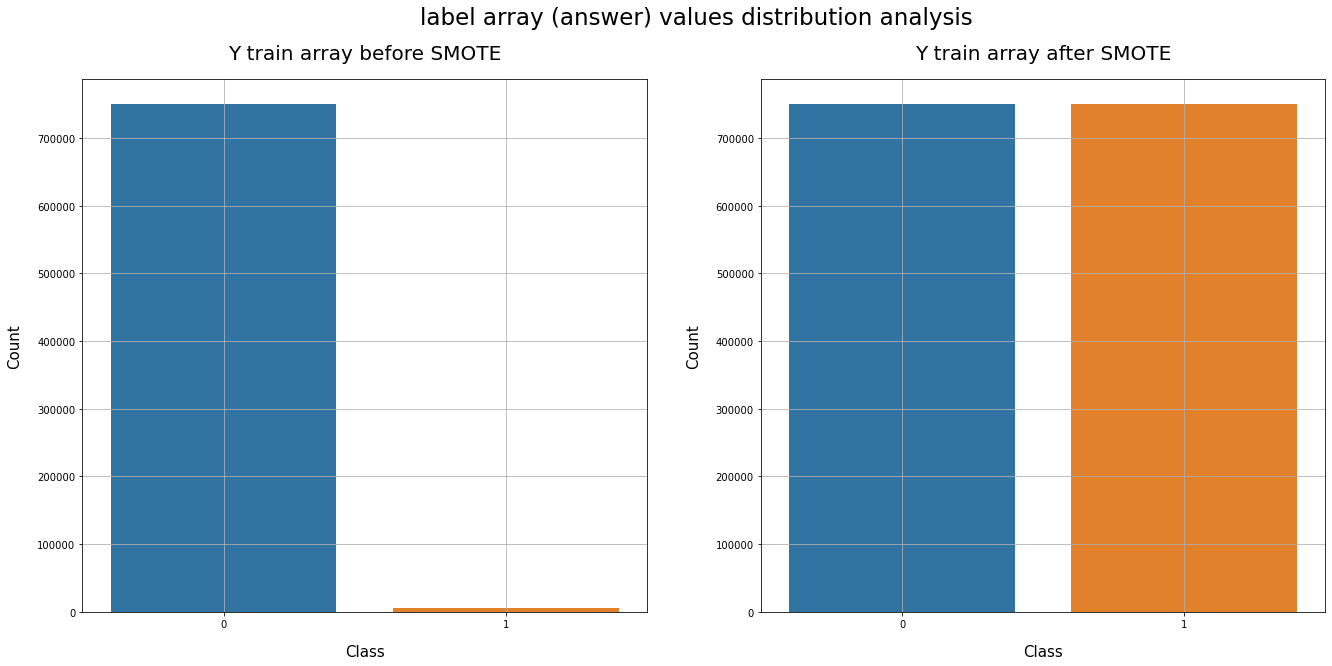

In [65]:
# create a figure with 1 row and 2 columns of axes
fig, axes = plt.subplots(1, 2, figsize= (20, 10))
fig.tight_layout(pad= 8.3)

# set the figure title and size
fig.suptitle("label array (answer) values distribution analysis", size= 23)

# set first axe's graph, title and labels
sns.countplot(ax= axes[0], x= y_train)
axes[0].set_title("Y train array before SMOTE", size= 20, pad= 20)
axes[0].set_xlabel("Class", size= 15, labelpad= 15)
axes[0].set_ylabel("Count", size= 15, labelpad= 15)
axes[0].grid()

# set second axe's graph, title and labels
sns.countplot(ax= axes[1], x= y_balanced)
axes[1].set_title("Y train array after SMOTE", size= 20, pad= 20)
axes[1].set_xlabel("Class", size= 15, labelpad= 15)
axes[1].set_ylabel("Count", size= 15, labelpad= 15)
axes[1].grid()

### <font color=green size= 5>6.7 CHECKPOINT </font>
***

In [66]:
# saving the manual selected columns
pickle.dump(manual_selected_features, open('../parameters/manual_selected_features.pkl', 'wb'))

# saving y and x balanced and train arrays
pickle.dump(x_train, open('../parameters/x_train.pkl', 'wb'))
pickle.dump(y_train, open('../parameters/y_train.pkl', 'wb'))
pickle.dump(x_balanced, open('../parameters/x_balanced.pkl', 'wb'))
pickle.dump(y_balanced, open('../parameters/y_balanced.pkl', 'wb'))

In [67]:
# opening the manual selected columns
manual_selected_features = pickle.load(open('../parameters/manual_selected_features.pkl', 'rb'))

# open y and x balanced arrays
x_train = pickle.load(open('../parameters/x_train.pkl', 'rb'))
y_train = pickle.load(open('../parameters/y_train.pkl', 'rb'))
x_balanced = pickle.load(open('../parameters/x_balanced.pkl', 'rb'))
y_balanced = pickle.load(open('../parameters/y_balanced.pkl', 'rb'))

# <font color=green size= 6> <b>7. MACHINE LEARNING </font></b>
***

## <font color=green size= 5>7.1 INSTANTIATE MODELS </font>
***

In [73]:
# instantiating dummy model as 'dummy'
dummy = DummyClassifier(random_state= 301)

# instantiating catboost model as 'cat'
cat = CatBoostClassifier(random_state= 301, verbose= False)

# instantiating Gaussian model as 'gnb'
gnb = GaussianNB()

# instantiating Random Forest model as 'rfc'
rfc = RandomForestClassifier(random_state= 301)

# instantiating Logistic Regression model as 'lr'
lr = LogisticRegression(random_state= 301)

# instantiating Linear Discrimination model as 'lda'
lda = LinearDiscriminantAnalysis()

# instantiating Kneighbors model as 'knc'
knc = KNeighborsClassifier(n_neighbors= 5, weights= 'distance', n_jobs= -1)

# instantiating XGBClassifier model as 'xgb'
xgb = XGBClassifier(random_state= 301, objective= 'binary:logistic')

# instantiating SGDC model as 'sgd'
sgd = SGDClassifier(random_state= 301, loss= 'log' , n_jobs= -1)

# instantiating LGBM model as 'lgbm'
lgbm = LGBMClassifier(random_state= 301, n_jobs= -1)

## <font color=green size= 5>7.2 MODELS TRAINING AND PERFORMANCE RESULTS </font>
***

### <font color=green size= 4>7.2.1 TRANING AND PRELIMINAR PERFORMANCE RESULTS </font>
***

In [74]:
# creating a list with the models instances
models =[lgbm, sgd, xgb, knc, lda, lr, rfc, gnb, cat, dummy]

# getting the models trained performance metrics for 'y_test' array (using the helper functions at section 1.2)
df_models_performance = get_models_performance(x_balanced, x_test, np.ravel(y_balanced), np.ravel(y_test), models)   

# displaying the 'df_models_performance' dataset and hightlight the maximum values for each column
df_models_performance.style.highlight_max(color= 'yellow')

Training LGBMClassifier...
Training SGDClassifier...
Training XGBClassifier...
[18:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training KNeighborsClassifier...
Training LinearDiscriminantAnalysis...
Training LogisticRegression...
Training RandomForestClassifier...
Training GaussianNB...
Training CatBoostClassifier...
Training DummyClassifier...


,model,precision,recall,f1_score,accuracy,kappa_score
0,LGBMClassifier,0.677955,0.989130,0.804501,0.996139,0.802620
2,SGDClassifier,0.154311,0.946146,0.265346,0.957925,0.255058
4,XGBClassifier,0.835004,0.987648,0.904934,0.998333,0.904100
6,KNeighborsClassifier,0.490748,0.930336,0.642552,0.991687,0.638754
8,LinearDiscriminantAnalysis,0.036268,0.910079,0.069756,0.805063,0.055161
10,LogisticRegression,0.143357,0.952075,0.249192,0.953925,0.238562
12,RandomForestClassifier,0.893781,0.972826,0.931630,0.998853,0.931053
14,GaussianNB,0.132927,0.700099,0.223431,0.960917,0.212805
16,CatBoostClassifier,0.776402,0.991601,0.870905,0.997639,0.869731
18,DummyClassifier,0.000000,0.000000,0.000000,0.991969,0.000000


***
**As seen above:**

On the business side we are aiming Recall score. Because only False Negative values (fraudulent transactions that our predict model let it pass) that have a negative impact over the BF company revenue.
<br>
<br>

So, we will choose the Top 4 best Recall models above to analyze.

### <font color=green size= 4>7.2.2 CONFUSION MATRIX INDICATOR </font>
***

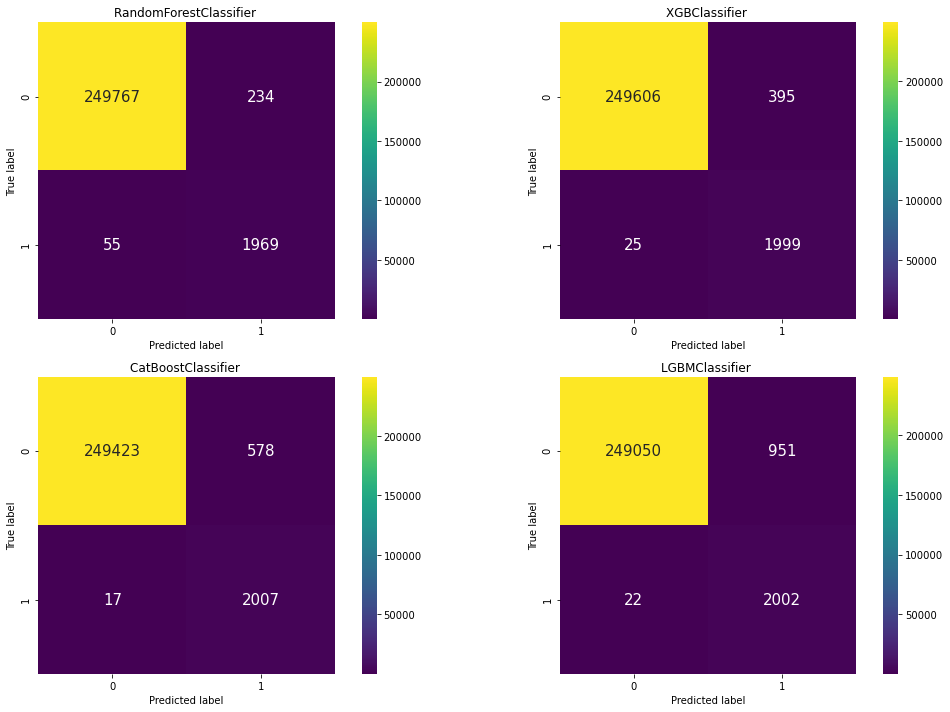

In [75]:
# creating a list with the top 4 recall score models
best_models = [rfc, xgb, cat, lgbm]

#setting threshold value
thresh = 0.50

# plotting confusion matrices for each model prediction array VS. 'y_test' array (using the helper functions at section 1.2)
plot_multiple_confusion_matrices(2, 2, x_test, y_test, best_models, thresh)

***
**As seen above:**


For the 'y_test' array predicting, the CatBoostClassifier,  LGBMClassifer and XGBClassifier models have the lowest False Negative values, with CatBoostClassier having the lowest one, by a slightly difference of 5 from LGBM Classifier. Which is important for the business interests.

### <font color=green size= 4>7.2.3 BRIER LOSS INDICATOR </font>
***

In [76]:
# predicting the probabilities to return class 1 for each one of the best models
y_pred_rfc_prob = rfc.predict_proba(x_test)[:,1]
y_pred_xgb_prob = xgb.predict_proba(x_test)[:,1]
y_pred_cat_prob = cat.predict_proba(x_test)[:,1]
y_pred_lgbm_prob = lgbm.predict_proba(x_test)[:,1]

# calculating the Brier Score Loss indicatior for each one of the best models 
rfc_bsl = brier_score_loss(y_test, y_pred_rfc_prob, pos_label= 1)
xgb_bsl = brier_score_loss(y_test, y_pred_xgb_prob, pos_label= 1)
cat_bsl = brier_score_loss(y_test, y_pred_cat_prob, pos_label= 1)
lgbm_bsl = brier_score_loss(y_test, y_pred_lgbm_prob, pos_label= 1)

# printing the Brier Score Loss indicatior calculated value for each one of the best models 
print("RFC - Brier Score loss: {}".format(rfc_bsl))
print("XGB - Brier Score loss: {}".format(xgb_bsl))
print("CAT - Brier Score loss: {}".format(cat_bsl))
print("LGBM - Brier Score loss: {}".format(lgbm_bsl))

RFC - Brier Score loss: 0.0009042487848427733
XGB - Brier Score loss: 0.0012935391105318023
CAT - Brier Score loss: 0.001837436946014975
LGBM - Brier Score loss: 0.0029075748100633085


***
- The Brier Score Loss measures the mean squared difference between the predicted probability and the actual outcome
- The Brier Score Loss fits analysis with categorical or binary outcomes. This is because the Brier Score Loss assumes that all possible outcomes are equivalently “distant” from one another. 
- The smaller the Brier score loss, the better. 

**As seen above:**

Random Forest Classifier and XGB Classifier have the lowests Brier Score Loss values. With the Random Forest Classifier having the lowest one, by a significante difference.

### <font color=green size= 4>7.2.4 ROC CURVE INDICATOR </font>
***

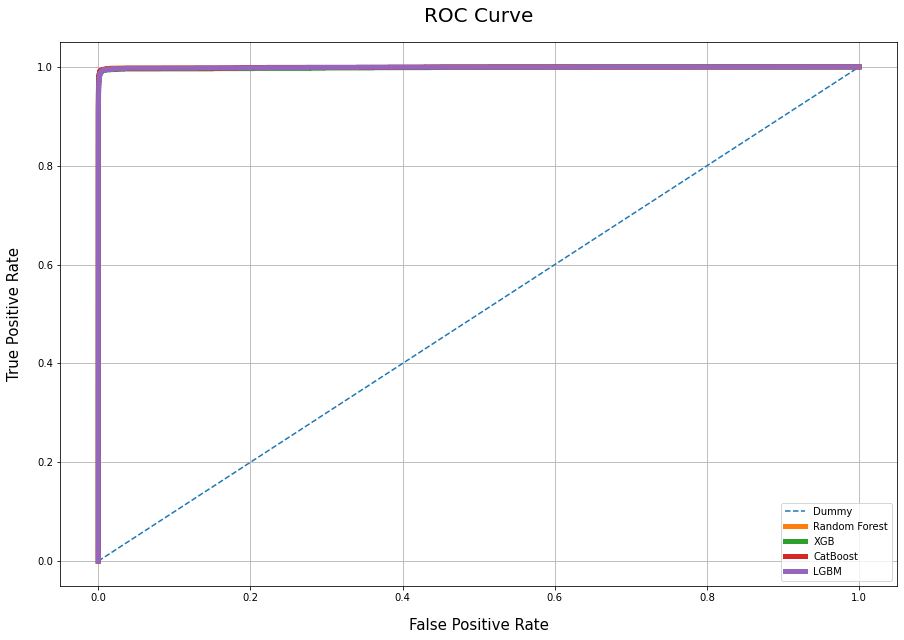

In [77]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize=(15,10))

# creating a list as a dummy classifier with the same size as 'y_test' array. Predicting all outcomes as class 0
dummy_probs = [0 for _ in range(len(y_test))]

# calculating the false posite rate and true positive rate by comparing 'y_test' and 'dummy_probs' array
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_probs)

# calculating the false posite rate and true positive rate for each one of the best models, by comparing 'y_test' and model probs array
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, y_pred_rfc_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_pred_xgb_prob)
cat_fpr, cat_tpr, _ = roc_curve(y_test, y_pred_cat_prob)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, y_pred_lgbm_prob)

# plotting the roc curve for each one of the best models
plt.plot(dummy_fpr, dummy_tpr, linestyle= '--', label= 'Dummy')
plt.plot(rfc_fpr, rfc_tpr, linestyle= '-', linewidth= 5 , label= 'RFC')
plt.plot(xgb_fpr, xgb_tpr, linestyle= '-', linewidth= 5 , label= 'XGB')
plt.plot(cat_fpr, cat_tpr, linestyle= '-', linewidth= 5 , label= 'CAT')
plt.plot(lgbm_fpr, lgbm_tpr, linestyle= '-', linewidth= 5 , label= 'LGBM')

# setting figure title, labels and grid
plt.title("ROC Curve", fontsize=20, pad = 20)
plt.xlabel('False Positive Rate', size = 15, labelpad = 15)
plt.ylabel('True Positive Rate', size = 15, labelpad = 15)
plt.grid()

# setting the figure legend
plt.legend()

# displaying the figure
plt.show()

***
**As seen above:**

For all models, the behavior is almost the same.

### <font color=green size= 4>7.2.4 CLASSIFICATION REPORT INDICATOR </font>
***

In [78]:
# predicting the output for x_test arrays for each one of the best models
y_pred_rfc = rfc.predict(x_test)
y_pred_xgb = xgb.predict(x_test)
y_pred_cat = cat.predict(x_test)
y_pred_lgbm = lgbm.predict(x_test)

# printing the classification report between the real and predicted arrays for each model
print('\nClassification Report for ' + type(rfc).__name__)
print(classification_report(y_test, y_pred_rfc))

print('Classification Report for ' + type(xgb).__name__)
print(classification_report(y_test, y_pred_xgb))

print('\nClassification Report for ' + type(cat).__name__)
print(classification_report(y_test, y_pred_cat))

print('\nClassification Report for ' + type(lgbm).__name__)
print(classification_report(y_test, y_pred_lgbm))


Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250001
           1       0.89      0.97      0.93      2024

    accuracy                           1.00    252025
   macro avg       0.95      0.99      0.97    252025
weighted avg       1.00      1.00      1.00    252025

Classification Report for XGBClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250001
           1       0.84      0.99      0.90      2024

    accuracy                           1.00    252025
   macro avg       0.92      0.99      0.95    252025
weighted avg       1.00      1.00      1.00    252025


Classification Report for CatBoostClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250001
           1       0.78      0.99      0.87      2024

    accuracy                           1.00   

***
**As seen above:**

- Random Forest Classifier and XGBClassifier models have almost the same classification report, with - Random Forest Classifier having, in general, better metrics.

- Taking only the Recall metrics, with we are more interested of, XGBClassifier have the better Recall for predicting the class '1'. 

So, with Random Forest Classifier having better metrics in general and a better Brier Score Loss value, but in the other side XGBClassifier having the lowest False Negative results and higher Recall value, we are going to cross validate both of them to see how they perform taking all dataset as train and test arrays.

## <font color=green size= 5>7.3 CROSS VALIDATION </font>
***

### <font color=green size= 4>7.3.1 RANDOM FOREST CLASSIFIER METRICS</font>
***

In [103]:
# combining the train and test features and labels. This is because that cross validation split the train and test dataset by itself
x_cv = pd.concat([x_train, x_test] , axis= 0)
y_cv = pd.concat([y_train, y_test] , axis= 0)

# resetting the combined arrays index
x_cv.reset_index(drop= True, inplace= True)
y_cv.reset_index(drop= True, inplace= True)

In [104]:
print('Cross Validation for Random Forest Classifier model:')

# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10)

# creating a cross validation analysis for 'rfc' model, with precision model interval evaluation
cv_scores_precision = cross_val_score(rfc, x_cv, np.ravel(y_cv), cv= cv, scoring= 'precision', n_jobs= -1) * 100
print("\n Precision interval: [{:.4f}%, {:.4f}%]".format(cv_scores_precision.mean() - cv_scores_precision.std()*2, cv_scores_precision.mean() + cv_scores_precision.std()*2)) 

# creating a cross validation analysis for 'rfc' model, with recall model interval evaluation
cv_scores_recall = cross_val_score(rfc, x_cv, np.ravel (y_cv), cv= cv, scoring = 'recall', n_jobs= -1) * 100
print("\n Recall interval: [{:.4f}%, {:.4f}%]".format(cv_scores_recall.mean() - cv_scores_recall.std()*2, cv_scores_recall.mean() + cv_scores_recall.std()*2)) 

# creating a cross validation analysis for 'rfc' model, with f1 score model interval evaluation
cv_scores_f1_score = cross_val_score(rfc, x_cv, np.ravel(y_cv), cv= cv, scoring= 'f1', n_jobs= -1) * 100
print("\n F1 Score interval: [{:.4f}%, {:.4f}%]".format(cv_scores_f1_score.mean() - cv_scores_f1_score.std()*2, cv_scores_f1_score.mean() + cv_scores_f1_score.std()*2)) 

# creating a cross validation analysis for 'rfc' model, with accuracy model interval evaluation
cv_scores_accuracy = cross_val_score(rfc, x_cv, np.ravel(y_cv), cv= cv, scoring= 'accuracy', n_jobs= -1) * 100
print("\n Accuracy interval: [{:.4f}%, {:.4f}%]".format(cv_scores_accuracy.mean() - cv_scores_accuracy.std()*2, cv_scores_accuracy.mean() + cv_scores_accuracy.std()*2)) 

Cross Validation for Random Forest Classifier model:

 Precision interval: [97.1186%, 99.1094%]

 Recall interval: [88.7973%, 92.2333%]

 F1 Score interval: [93.0362%, 95.2826%]

 Accuracy interval: [99.8929%, 99.9268%]


### <font color=green size= 4>7.3.2 XGBOOST CLASSIFIER METRICS</font>
***

In [105]:
# combining the train and test features and labels. This is because that cross validation split the train and test dataset by itself
x_cv = pd.concat([x_train, x_test] , axis= 0)
y_cv = pd.concat([y_train, y_test] , axis= 0)

# resetting the combined arrays index
x_cv.reset_index(drop= True, inplace= True)
y_cv.reset_index(drop= True, inplace= True)

In [106]:
print('Cross Validation for XGBoost Classifier model:')

# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10)

# creating a cross validation analysis for 'xgb' model, with precision model interval evaluation
cv_scores_precision = cross_val_score(xgb, x_cv, np.ravel(y_cv), cv= cv, scoring= 'precision', n_jobs= -1) * 100
print("\n Precision interval: [{:.4f}%, {:.4f}%]".format(cv_scores_precision.mean() - cv_scores_precision.std()*2, cv_scores_precision.mean() + cv_scores_precision.std()*2)) 

# creating a cross validation analysis for 'xgb' model, with recall model interval evaluation
cv_scores_recall = cross_val_score(xgb, x_cv, np.ravel (y_cv), cv= cv, scoring = 'recall', n_jobs= -1) * 100
print("\n Recall interval: [{:.4f}%, {:.4f}%]".format(cv_scores_recall.mean() - cv_scores_recall.std()*2, cv_scores_recall.mean() + cv_scores_recall.std()*2)) 

# creating a cross validation analysis for 'xgb' model, with f1 score model interval evaluation
cv_scores_f1_score = cross_val_score(xgb, x_cv, np.ravel(y_cv), cv= cv, scoring= 'f1', n_jobs= -1) * 100
print("\n F1 Score interval: [{:.4f}%, {:.4f}%]".format(cv_scores_f1_score.mean() - cv_scores_f1_score.std()*2, cv_scores_f1_score.mean() + cv_scores_f1_score.std()*2)) 

# creating a cross validation analysis for 'xgb' model, with accuracy model interval evaluation
cv_scores_accuracy = cross_val_score(xgb, x_cv, np.ravel(y_cv), cv= cv, scoring= 'accuracy', n_jobs= -1) * 100
print("\n Accuracy interval: [{:.4f}%, {:.4f}%]".format(cv_scores_accuracy.mean() - cv_scores_accuracy.std()*2, cv_scores_accuracy.mean() + cv_scores_accuracy.std()*2)) 

Cross Validation for XGBoost Classifier model:

 Precision interval: [96.9590%, 99.0219%]

 Recall interval: [93.0874%, 95.8965%]

 F1 Score interval: [95.1838%, 97.2325%]

 Accuracy interval: [99.9241%, 99.9563%]


***
**As seen above:**

- Random Forest Classifier and XGBClassifier approximately the same Precision interval.
<br>

- XGBClassifier have a significant higher Recall interval than Random Forest Classifier, which is a major importance metrics for our business proposal
<br>

- XGBClassifier have a significant higher F1 score interval than Random Forest Classifier, caused by the higher Recall interval.
<br>

- Random Forest Classifier and XGBClassifier approximately the same Accuracy interval.
<br>

So, taking all these metrics analysis in account, we will choose the XGBClassifier model to work.

## <font color=green size= 5>7.4 CHECKPOINT </font>
***

In [107]:
# training the 'xgb' model, because it wasn't before
xgb.fit(x_balanced, np.ravel(y_balanced))

[00:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=301,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
# saving the trained XGB model as a pickle file
pickle.dump(xgb, open('../models/xgb_model.pkl', 'wb'))
    
# saving the cross validation metrics 
pickle.dump(cv_scores_precision, open('../parameters/cv_scores_precision.pkl', 'wb'))
pickle.dump(cv_scores_recall, open('../parameters/cv_scores_recall.pkl', 'wb'))
pickle.dump(cv_scores_f1_score, open('../parameters/cv_scores_f1_score.pkl', 'wb'))
pickle.dump(cv_scores_accuracy, open('../parameters/cv_scores_accuracy.pkl', 'wb'))

In [109]:
# opening the trained XGB model as a pickle file
xgb = pickle.load(open('../models/xgb_model.pkl', 'rb'))

# opening the cross validation metrics 
cv_scores_precision = pickle.load(open('../parameters/cv_scores_precision.pkl', 'rb'))
cv_scores_recall = pickle.load(open('../parameters/cv_scores_recall.pkl', 'rb'))
cv_scores_f1_score = pickle.load(open('../parameters/cv_scores_f1_score.pkl', 'rb'))
cv_scores_accuracy = pickle.load(open('../parameters/cv_scores_accuracy.pkl', 'rb'))

# <font color=green size= 6> <b>8. HYPERPARAMETERS FINE TUNING </font></b>
***

## <font color=green size= 5>8.1 RANDOM SEARCH </font>
***

In [110]:
# creating a new XGB model, not tuned
xgb_not_tuned = XGBClassifier(random_state= 301, n_jobs= -1)

In [111]:
# creating a dictionary with the hyperparameters to go through
params = {'max_depth': np.arange(2, 12, 2),  
              'alpha': [0, .001, .01, .1],
              'learning_rate': np.linspace(0.001, 0.6, 15),
              'colsample_bytree': np.linspace(0.1, 1, 5),
              'subsample': np.linspace(0.25, 1, 15),
              'n_estimators': np.arange(10, 105, 15)}

In [112]:
# creating the RandomizedSearchCV method over XGB model, going through all hyperparameters in 'params' dictionary
xgb_not_tuned_cv = RandomizedSearchCV(estimator= xgb_not_tuned, 
                                param_distributions= params,
                                n_iter= 100,
                                scoring= 'recall',                                
                                cv= 5,
                                verbose= 2,
                                random_state= 301,
                                n_jobs= -1)

In [113]:
# training the RandomizedSearchCV method over XGB model with 'x_balanced' and 'y_balanced' arrays
xgb_not_tuned_cv.fit(x_balanced, np.ravel(y_balanced))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[03:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_

In [114]:
# instantiating the best XGB model as 'xgb_tuned'
xgb_tuned = xgb_not_tuned_cv.best_estimator_

# getting the trained 'xgb_tuned' model performance's metrics for 'y_test' array (using the helper functions at section 1.2)
df_tuned = get_models_performance(x_balanced, x_test, np.ravel(y_balanced), np.ravel(y_test), [xgb_tuned])

# printing the 'xgb_not_tuned' model best hyparameters found at RandomizedSearchCV method
print("\n XGBoost Model tuned hyper parameters: \n {}".format(xgb_not_tuned_cv.best_params_)) 

# printing the 'xgb_not_tuned' model best accuracy found at RandomizedSearchCV method
print("\n XGBoost Model tuned best accuracy score: {:.4f}%".format(xgb_not_tuned_cv.best_score_ * 100))

# displaying the 'df_tuned' dataset
df_tuned

Training XGBClassifier...
[03:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 XGBoost Model tuned hyper parameters: 
 {'subsample': 0.5714285714285714, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.34328571428571425, 'colsample_bytree': 1.0, 'alpha': 0.001}

 XGBoost Model tuned best accuracy score: 99.9805%


,model,precision,recall,f1_score,accuracy,kappa_score
0,XGBClassifier,0.883215,0.982708,0.930309,0.998818,0.929714


***
**PREENCHER**

## <font color=green size= 5>8.2 CALIBRATE THE CURVE </font>
***

In [115]:
# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10)

# training the the 'xgb_tuned' model
xgb_tuned.fit(x_balanced, np.ravel(y_balanced))

# defining and fit the calibration model
xgb_tuned_calibrated = CalibratedClassifierCV(base_estimator= xgb_tuned, method= 'isotonic', cv= cv)

# training the 'xgb_tuned_calibrated' model
xgb_tuned_calibrated.fit(x_train, np.ravel(y_train))

[03:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:34:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:34:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

CalibratedClassifierCV(base_estimator=XGBClassifier(alpha=0.001, base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1.0,
                                                    gamma=0, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints='',
                                                    learning_rate=0.34328571428571425,
                                                    max_delta_step=0,
                                                    max_depth=8,
                                                    min_child_weight=1,
                                                    missing=nan,
                                           

## <font color=green size= 5>8.3 CROSS VALIDATION </font>
***

### <font color=green size= 4>8.3.1 XGBOOST CLASSIFIER TUNED MODEL METRICS</font>
***

In [116]:
# combining the train and test features and labels. This because that crossvalidation split the train and test dataset by itself
x_cv = pd.concat([x_train, x_test] , axis= 0)
y_cv = pd.concat([y_train, y_test] , axis= 0)

# resetting the combined arrays index
x_cv.reset_index(drop= True, inplace= True)
y_cv.reset_index(drop= True, inplace= True)

In [117]:
print('Cross Validation for XGBoost Classifier tuned model:')

# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 5 stratified arrays.
cv = StratifiedKFold(n_splits= 5)

# creating a cross validation analysis for 'xgb_tuned' model, with precision model interval evaluation
cv_scores_precision_tuned = cross_val_score(xgb_tuned, x_cv, np.ravel(y_cv), cv= cv, scoring= 'precision', n_jobs= -1) * 100
print("\n Precision interval: [{:.4f}%, {:.4f}%]".format(cv_scores_precision_tuned.mean() - cv_scores_precision_tuned.std()*2, cv_scores_precision_tuned.mean() + cv_scores_precision_tuned.std()*2)) 

# creating a cross validation analysis for 'xgb_tuned' model, with recall model interval evaluation
cv_scores_recall_tuned = cross_val_score(xgb_tuned, x_cv, np.ravel (y_cv), cv= cv, scoring = 'recall', n_jobs= -1) * 100
print("\n Recall interval: [{:.4f}%, {:.4f}%]".format(cv_scores_recall_tuned.mean() - cv_scores_recall_tuned.std()*2, cv_scores_recall_tuned.mean() + cv_scores_recall_tuned.std()*2)) 

# creating a cross validation analysis for 'xgb_tuned' model, with f1 score model interval evaluation
cv_scores_f1_score_tuned = cross_val_score(xgb_tuned, x_cv, np.ravel(y_cv), cv= cv, scoring= 'f1', n_jobs= -1) * 100
print("\n F1 Score interval: [{:.4f}%, {:.4f}%]".format(cv_scores_f1_score_tuned.mean() - cv_scores_f1_score_tuned.std()*2, cv_scores_f1_score_tuned.mean() + cv_scores_f1_score_tuned.std()*2)) 

# creating a cross validation analysis for 'xgb_tuned' model, with accuracy model interval evaluation
cv_scores_accuracy_tuned = cross_val_score(xgb_tuned, x_cv, np.ravel(y_cv), cv= cv, scoring= 'accuracy', n_jobs= -1) * 100
print("\n Accuracy interval: [{:.4f}%, {:.4f}%]".format(cv_scores_accuracy_tuned.mean() - cv_scores_accuracy_tuned.std()*2, cv_scores_accuracy_tuned.mean() + cv_scores_accuracy_tuned.std()*2)) 

Cross Validation for XGBoost Classifier tuned model:

 Precision interval: [96.7264%, 98.0107%]

 Recall interval: [93.5403%, 95.5916%]

 F1 Score interval: [95.3012%, 96.5907%]

 Accuracy interval: [99.9258%, 99.9458%]


### <font color=green size= 4>8.3.2 XGBOOST CLASSIFIER TUNED & CALIBRATED MODEL METRICS</font>
***

In [118]:
# combining the train and test features and labels. This because that crossvalidation split the train and test dataset by itself
x_cv = pd.concat([x_train, x_test] , axis= 0)
y_cv = pd.concat([y_train, y_test] , axis= 0)

# resetting the combined arrays index
x_cv.reset_index(drop= True, inplace= True)
y_cv.reset_index(drop= True, inplace= True)

In [119]:
print('Cross Validation for XGBoost Classifier tuned & calibrated model:')

# create the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10)

# creating a cross validation analysis for 'xgb_tuned' model, with precision model interval evaluation
cv_scores_precision_tuned_calibrated = cross_val_score(xgb_tuned_calibrated, x_cv, np.ravel(y_cv), cv= cv, scoring= 'precision', n_jobs= -1) * 100
print("\n Precision interval: [{:.4f}%, {:.4f}%]".format(cv_scores_precision_tuned.mean() - cv_scores_precision_tuned.std()*2, cv_scores_precision_tuned.mean() + cv_scores_precision_tuned.std()*2)) 

# creating a cross validation analysis for 'xgb_tuned' model, with recall model interval evaluation
cv_scores_recall_tuned_calibrated = cross_val_score(xgb_tuned_calibrated, x_cv, np.ravel (y_cv), cv= cv, scoring = 'recall', n_jobs= -1) * 100
print("\n Recall interval: [{:.4f}%, {:.4f}%]".format(cv_scores_recall_tuned.mean() - cv_scores_recall_tuned.std()*2, cv_scores_recall_tuned.mean() + cv_scores_recall_tuned.std()*2)) 

# creating a cross validation analysis for 'xgb_tuned' model, with f1 score model interval evaluation
cv_scores_f1_score_tuned_calibrated = cross_val_score(xgb_tuned_calibrated, x_cv, np.ravel(y_cv), cv= cv, scoring= 'f1', n_jobs= -1) * 100
print("\n F1 Score interval: [{:.4f}%, {:.4f}%]".format(cv_scores_f1_score_tuned.mean() - cv_scores_f1_score_tuned.std()*2, cv_scores_f1_score_tuned.mean() + cv_scores_f1_score_tuned.std()*2)) 

# creating a cross validation analysis for 'xgb_tuned' model, with accuracy model interval evaluation
cv_scores_accuracy_tuned_calibrated = cross_val_score(xgb_tuned_calibrated, x_cv, np.ravel(y_cv), cv= cv, scoring= 'accuracy', n_jobs= -1) * 100
print("\n Accuracy interval: [{:.4f}%, {:.4f}%]".format(cv_scores_accuracy_tuned.mean() - cv_scores_accuracy_tuned.std()*2, cv_scores_accuracy_tuned.mean() + cv_scores_accuracy_tuned.std()*2)) 

Cross Validation for XGBoost Classifier tuned & calibrated model:

 Precision interval: [96.7264%, 98.0107%]

 Recall interval: [93.5403%, 95.5916%]

 F1 Score interval: [95.3012%, 96.5907%]

 Accuracy interval: [99.9258%, 99.9458%]


## <font color=green size= 5>8.4 CHECKPOINT</font>
***

In [120]:
# saving the trained XGB tuned model as a pickle file
pickle.dump(xgb_tuned, open('../models/xgb_model_tuned.pkl', 'wb'))

# saving the trained XGB tuned & calibrated model as a pickle file
pickle.dump(xgb_tuned_calibrated, open('../models/xgb_model_tuned_calibrated.pkl', 'wb'))

# saving the cross validation metrics 
pickle.dump(cv_scores_precision_tuned, open('../parameters/cv_scores_precision_tuned.pkl', 'wb'))
pickle.dump(cv_scores_recall_tuned, open('../parameters/cv_scores_recall_tuned.pkl', 'wb'))
pickle.dump(cv_scores_f1_score_tuned, open('../parameters/cv_scores_f1_score_tuned.pkl', 'wb'))
pickle.dump(cv_scores_accuracy_tuned, open('../parameters/cv_scores_accuracy_tuned.pkl', 'wb'))
pickle.dump(cv_scores_precision_tuned_calibrated, open('../parameters/cv_scores_precision_tuned_calibrated.pkl', 'wb'))
pickle.dump(cv_scores_recall_tuned_calibrated, open('../parameters/cv_scores_recall_tuned_calibrated.pkl', 'wb'))
pickle.dump(cv_scores_f1_score_tuned_calibrated, open('../parameters/cv_scores_f1_score_tuned_calibrated.pkl', 'wb'))
pickle.dump(cv_scores_accuracy_tuned_calibrated, open('../parameters/cv_scores_accuracy_tuned_calibrated.pkl', 'wb'))

In [121]:
# opening the trained XGB tuned model as a pickle file
xgb_tuned = pickle.load(open('../models/xgb_model_tuned.pkl', 'rb'))

# open the trained XGB tuned & calibrated model as a pickle file
xgb_tuned_calibrated = pickle.load(open('../models/xgb_model_tuned_calibrated.pkl', 'rb'))

# open the cross validation metrics 
cv_scores_precision_tuned = pickle.load(open('../parameters/cv_scores_precision_tuned.pkl', 'rb'))
cv_scores_recall_tuned = pickle.load(open('../parameters/cv_scores_recall_tuned.pkl', 'rb'))
cv_scores_f1_score_tuned = pickle.load(open('../parameters/cv_scores_f1_score_tuned.pkl', 'rb'))
cv_scores_accuracy_tuned = pickle.load(open('../parameters/cv_scores_accuracy_tuned.pkl', 'rb'))
cv_scores_precision_tuned_calibrated = pickle.load(open('../parameters/cv_scores_precision_tuned_calibrated.pkl', 'rb'))
cv_scores_recall_tuned_calibrated = pickle.load(open('../parameters/cv_scores_recall_tuned_calibrated.pkl', 'rb'))
cv_scores_f1_score_tuned_calibrated = pickle.load(open('../parameters/cv_scores_f1_score_tuned_calibrated.pkl', 'rb'))
cv_scores_accuracy_tuned_calibrated = pickle.load(open('../parameters/cv_scores_accuracy_tuned_calibrated.pkl', 'rb'))

# <font color=green size= 6>9. XGBOOST MODELS PERFORMANCE EVALUATION</font>
***

## <font color=green size= 5>9.1 INDICATORS </font>
***

### <font color=green size= 4>9.1.1 CONFUSION MATRIX INDICATOR </font>
***

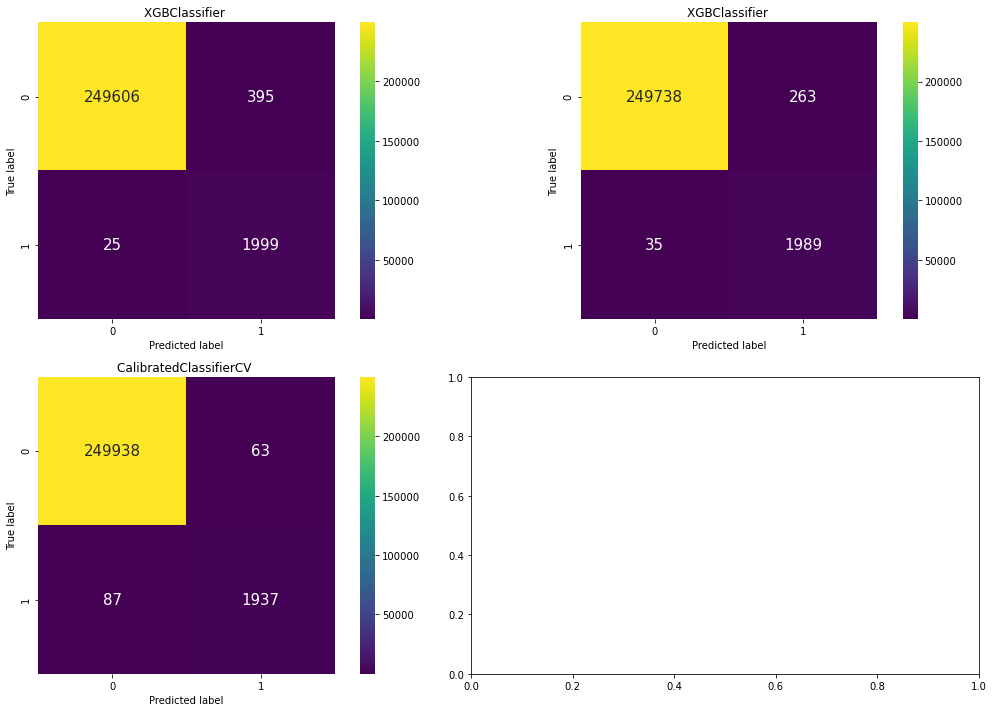

In [122]:
# create a list with the XGB models
models = [xgb, xgb_tuned, xgb_tuned_calibrated]

#set threshold value
thresh = 0.50

# plot confusion matrices (2x2) using the helper functions (section 1.3) for each model prediction x model test
plot_multiple_confusion_matrices(2, 2, x_test, y_test, models, thresh)

***
**As seen above:**

- For the 'y_test' array predicting, the XGB Default and the XGB Tuned models have the lowest False Negative values between them all, with XGB Default having the lowest one, by a slightly difference of 10. Which is important for the business interests.

### <font color=green size= 4>9.1.2 BRIER SCORE LOSS INDICATOR </font>
***

In [123]:
# predicting the probabilities to return class 1 for each one of the XGB models
xgb_prob = xgb.predict_proba(x_test)[:,1]
xgb_tuned_prob = xgb_tuned.predict_proba(x_test)[:,1]
xgb_tuned_calibrated_prob = xgb_tuned_calibrated.predict_proba(x_test)[:,1]

# calculating the Brier Score Loss indicatior for each one of the XGB models
xgb_prob_bsl = brier_score_loss(y_test, xgb_prob, pos_label= 1)
xgb_tuned_prob_bsl = brier_score_loss(y_test, xgb_tuned_prob, pos_label= 1)
xgb_tuned_calibrated_bsl = brier_score_loss(y_test, xgb_tuned_calibrated_prob, pos_label= 1)

# printing the Brier Score Loss indicatior calculated value for each one of the XGB models 
print("XGB - Brier Score loss: {}".format(xgb_prob_bsl))
print("XGB tuned - Brier Score loss: {}".format(xgb_tuned_prob_bsl))
print("XGB tuned & calibrated - Brier Score loss: {}".format(xgb_tuned_calibrated_bsl))

 Brier Score loss - XGB  0.0012935391105318023
 Brier Score loss - XGB Tuned  0.0009138822725738937
 Brier Score loss - XGB Tuned + Calibrated 0.00044314378367771014


***
- The Brier Score Loss measures the mean squared difference between the predicted probability and the actual outcome
- The Brier Score Loss fits analysis with categorical or binary outcomes. This is because the Brier Score Loss assumes that all possible outcomes are equivalently “distant” from one another. 
- The smaller the Brier score loss, the better. 

**As seen above:**

XGB Tuned & Calibrated model has the lowest Brier Score Loss by far, between them all. Its Brier Score Loss value is less than a half of XGB Tuned's Brier Score Loss value.

### <font color=green size= 4>9.1.3 ROC CURVE INDICATOR </font>
***

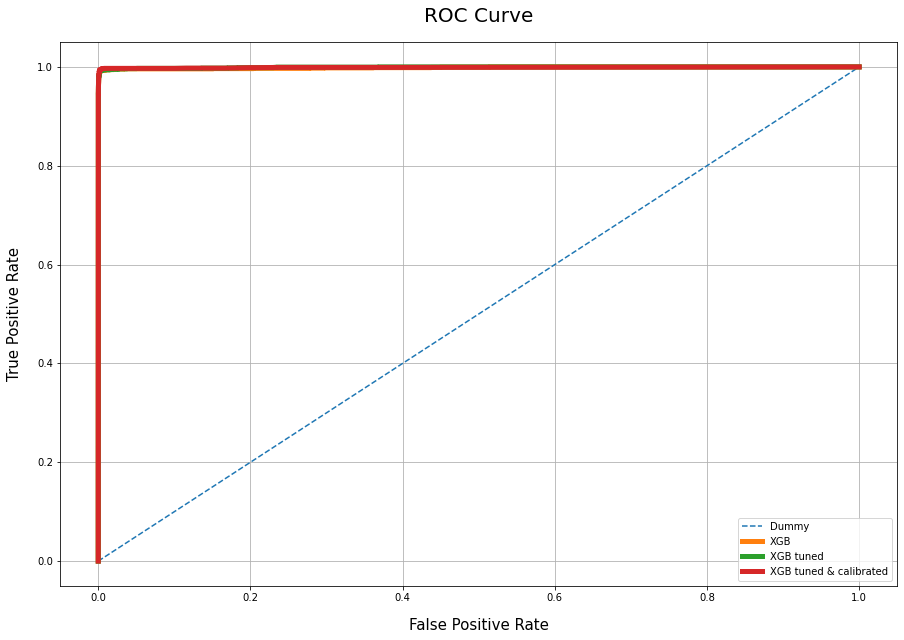

In [124]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize=(15,10))

# creating a list/array as a dummy classifier with the same size as 'y_test' array. Predicting all outcomes as class 0
dummy_probs = [0 for _ in range(len(y_test))]

# calculating the false posite rate and true positive rate by comparing 'y_test' and 'dummy_probs' array
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_probs)

# calculating the false posite rate and true positive rate for each one of the best models, by comparing 'y_test' and model probs array
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
xgb_tuned_fpr, xgb_tuned_tpr, _ = roc_curve(y_test, xgb_tuned_prob)
xgb_tuned_calibrated_fpr, xgb_tuned_calibrated_tpr, _ = roc_curve(y_test, xgb_tuned_calibrated_prob)

# plotting the roc curve for each one of the best models
plt.plot(dummy_fpr, dummy_tpr, linestyle= '--', label= 'Dummy')
plt.plot(xgb_fpr, xgb_tpr, linestyle= '-', linewidth= 5 , label= 'XGB')
plt.plot(xgb_tuned_fpr, xgb_tuned_tpr, linestyle= '-', linewidth= 5 , label= 'XGB tuned')
plt.plot(xgb_tuned_calibrated_fpr, xgb_tuned_calibrated_tpr, linestyle= '-', linewidth= 5 , label= 'XGB tuned & calibrated')

# setting figure title, labels and grid
plt.title("ROC Curve", fontsize=20, pad = 20)
plt.xlabel('False Positive Rate', size = 15, labelpad = 15)
plt.ylabel('True Positive Rate', size = 15, labelpad = 15)
plt.grid()

# displaying the graph legend
plt.legend()

# displaying the figure
plt.show()

***
**As seen above:**

For all XGB models, the behavior is almost the same. With some points the Tuned & Calibrated surpassing the others.

## <font color=green size= 5>9.2 FINAL METRICS CLASSIFICATION REPORT </font>
***

In [125]:
# creating a dictionary with the XGBoost Classifier model metrics
dict_xgb = {'Algorithm': 'XGBoost Classifier', 
            'Precision interval': f'{round(cv_scores_precision.mean(), 4)}% (+/-{round(cv_scores_precision.std(), 4)}%)',
            'Recall interval': f'{round(cv_scores_recall.mean(), 4)}% (+/-{round(cv_scores_recall.std(), 4)}%)',
            'F1_score interval': f'{round(cv_scores_f1_score.mean(), 4)}% (+/-{round(cv_scores_f1_score.std(), 4)}%)',
            'Accuracy interval': f'{round(cv_scores_accuracy.mean(), 4)}% (+/-{round(cv_scores_accuracy.std(), 4)}%)'}

# creating a dictionary with the XGBoost Classifier tuned model metrics
dict_xgb_tuned = {'Algorithm': 'XGBoost Classifier Tuned', 
            'Precision interval': f'{round(cv_scores_precision_tuned.mean(), 4)}% (+/-{round(cv_scores_precision_tuned.std(), 4)}%)',
            'Recall interval': f'{round(cv_scores_recall_tuned.mean(), 4)}% (+/-{round(cv_scores_recall_tuned.std(), 4)}%)',
            'F1_score interval': f'{round(cv_scores_f1_score_tuned.mean(), 4)}% (+/-{round(cv_scores_f1_score_tuned.std(), 4)}%)',
            'Accuracy interval': f'{round(cv_scores_accuracy_tuned.mean(), 4)}% (+/-{round(cv_scores_accuracy_tuned.std(), 4)}%)'}

# creating a dictionary with the XGBoost Classifier tuned and calibrated model metrics
dict_xgb_tuned_calibrated = {'Algorithm': 'XGBoost Classifier Tuned & Calibrated', 
            'Precision interval': f'{round(cv_scores_precision_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_precision_tuned_calibrated.std(), 4)}%)',
            'Recall interval': f'{round(cv_scores_recall_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_recall_tuned_calibrated.std(), 4)}%)',
            'F1_score interval': f'{round(cv_scores_f1_score_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_f1_score_tuned_calibrated.std(), 4)}%)',
            'Accuracy interval': f'{round(cv_scores_accuracy_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_accuracy_tuned_calibrated.std(), 4)}%)'}

In [126]:
# modifying the dictionaries to the pandas can transform it into a dataset
dict_xgb = {k:[v] for k,v in dict_xgb.items()}
dict_xgb_tuned = {k:[v] for k,v in dict_xgb_tuned.items()}
dict_xgb_tuned_calibrated = {k:[v] for k,v in dict_xgb_tuned_calibrated.items()}

# creating each model metrics dataset
df_xgb = pd.DataFrame(dict_xgb)
df_xgb_tuned = pd.DataFrame(dict_xgb_tuned)
df_xgb_tuned_calibrated = pd.DataFrame(dict_xgb_tuned_calibrated)

# combining the metrics datasets into a dataset to compare
df_models_comparision = pd.concat([df_xgb, df_xgb_tuned, df_xgb_tuned_calibrated])

# returning the dataset
df_models_comparision

,Algorithm,Precision interval,Recall interval,F1_score interval,Accuracy interval
0,XGBoost Classifier,97.9905% (+/-0.5157%),94.492% (+/-0.7023%),96.2082% (+/-0.5122%),99.9402% (+/-0.008%)
0,XGBoost Classifier Tuned,97.3686% (+/-0.3211%),94.566% (+/-0.5128%),95.946% (+/-0.3224%),99.9358% (+/-0.005%)
0,XGBoost Classifier Tuned & Calibrated,97.3952% (+/-0.6814%),95.9122% (+/-0.7035%),96.646% (+/-0.5295%),99.9465% (+/-0.0084%)


***
**As seen above:**

- All XGB models have almost the same metrics, in general
<br>

- XGB Default have a higher Precision than the others XGB models. Which reduces the BF company revenue, because the company wins 5\% for each transaction falsely accused as fraudulent (False Positive). So it will be cut out.
<br>

- XGB Tuned & Calibrated have a slightly higher Precision than the others XGB Tuned, something like 0,027\%. Which reduces the BF company revenue, as mentioned before.
<br>

- XGB Tuned & Calibrated have a higher Recall than the XGB Tuned, which is a major importance metrics for our business proposal

So, even with the slightly higher Precision interval, we will choose the the XGB Tuned & Calibrated model as the final model to propose,  because of it's significant higher Recall.

# <font color=green size= 6> <b>10. BUSINESS PERFORMANCE </font></b>
***

- **We are going to consider all transactions amounts to be the median value($ 74871,94). Because the dataset is highly skewed**

In [1]:
# setting the general information
num_total_transactions = 6362620
num_total_fraud_transactions = 8097
num_total_non_fraud_transactions = num_total_transactions - num_total_fraud_transactions

# priting the general information
print(f'Transactions informations:')
print(f' Amount of transactions: {num_total_transactions}')
print(f' Amount of fraudulent transactions: {num_total_fraud_transactions}')
print(f' Amount of non fraudulent transactions: {num_total_non_fraud_transactions}')


# setting the model averange recall
model_recall = 95.9122 / 100

# setting the model recall deviation
model_recall_deviation = 0.7035 / 100

# setting the model averange precision
model_precision = 97.3952 / 100

# setting the model precision deviation
model_precision_deviation = 0.6814 / 100


# calculating the best and worst recall metrics
upper_model_recall = model_recall + model_recall_deviation  
lower_model_recall = model_recall - model_recall_deviation

# calculating the best and worst precision metrics
upper_model_precision = model_precision + model_precision_deviation  
lower_model_precision = model_precision - model_precision_deviation



# BEST CASE SCENARIO MODEL PERFORMANCE

# calculating the amount of real fraud transactions that the model got it right (TP)
upper_num_TP_transactions = num_total_fraud_transactions * upper_model_recall

# calculating the amount of real fraud transactions that the model got it wrong (FN)
upper_num_FN_transactions = num_total_fraud_transactions * (1 - upper_model_recall)


# calculating the amount of real non fraud transactions that the model got it wrong (FP)
upper_num_FP_transactions = (upper_num_TP_transactions / lower_model_precision) - upper_num_TP_transactions  
# We use the lower_model_precision here because it creates more FP values, and FP values increases the company revenue

# priting the best case scenario's transactions informations
print(f'\nBest case scenario model perfomance:')
print(f' Amount of fraudulent transactions that the model got it right (TP): {int(upper_num_TP_transactions)}')
print(f' Amount of fraudulent transactions that the model got it wrong (FN): {int(upper_num_FN_transactions)}')
print(f' Amount of non fraudulent transactions that the model got it wrong (FP): {int(upper_num_FP_transactions)}')
print(f' Amount of non fraudulent transactions that the model got it right (TN): {int(num_total_transactions - (upper_num_TP_transactions + upper_num_FN_transactions + upper_num_FP_transactions))}')



# WORST CASE SCENARIO MODEL PERFORMANCE

# calculating the amount of real fraud transactions that the model got it right (TP)
lower_num_TP_transactions = num_total_fraud_transactions * lower_model_recall

# calculating the amount of real fraud transactions that the model got it wrong (FN)
lower_num_FN_transactions = num_total_fraud_transactions * (1 - lower_model_recall)

# calculating the amount of real non fraud transactions that the model got it wrong (FP)
lower_num_FP_transactions = (lower_num_TP_transactions / upper_model_precision) - lower_num_TP_transactions  
# We use the upper_model_precision here because it creates more FP values, and FP values descreases the company revenue

# priting the best case scenario's transactions informations
print(f'\nWorst case scenario model perfomance:')
print(f' Amount of fraudulent transactions that the model got it right (TP): {int(lower_num_TP_transactions)}')
print(f' Amount of fraudulent transactions that the model got it wrong (FN): {int(lower_num_FN_transactions)}')
print(f' Amount of non fraudulent transactions that the model got it wrong (FP): {int(lower_num_FP_transactions)}')
print(f' Amount of non fraudulent transactions that the model got it right (TN): {int(num_total_transactions - (lower_num_TP_transactions + lower_num_FN_transactions + upper_num_FP_transactions))}')

# setting the median transaction amount value
median_transaction_amount = 74871.8


# BEST CASE SCENARIO BUSINESS PERFORMANCE

# calculating the best scenario's revenues for TP, FP and FN
upper_TP_amount = 0.25 * median_transaction_amount * upper_num_TP_transactions
upper_FP_amount = 0.05 * median_transaction_amount * upper_num_FP_transactions
upper_FN_amount = 1 * median_transaction_amount * upper_num_FN_transactions

# calculating the best case scenario's total revenue
upper_total_revenue = upper_TP_amount + upper_FP_amount - upper_FN_amount

# printing the best case scenario's total revenue
print(f'\nBest case scenario business performance:')
print(f' BFC total revenue: $ {upper_total_revenue:,.2f}')


# WORST CASE SCENARIO BUSINESS PERFORMANCE

# calculating the worst case scenario's total revenue
lower_TP_amount = 0.25 * median_transaction_amount * lower_num_TP_transactions
lower_FP_amount = 0.05 * median_transaction_amount * lower_num_FP_transactions
lower_FN_amount = 1 * median_transaction_amount * lower_num_FN_transactions

# calculating the best scenario's total revenue
lower_total_revenue = lower_TP_amount + lower_FP_amount - lower_FN_amount

# printing the worst case scenario's total revenue
print(f'\nWorst case scenario business performance:')
print(f' BFC total revenue: $ {lower_total_revenue:,.2f}')

Transactions informations:
 Amount of transactions: 6362620
 Amount of fraudulent transactions: 8097
 Amount of non fraudulent transactions: 6354523

Best case scenario model perfomance:
 Amount of fraudulent transactions that the model got it right (TP): 7822
 Amount of fraudulent transactions that the model got it wrong (FN): 274
 Amount of non fraudulent transactions that the model got it wrong (FP): 265
 Amount of non fraudulent transactions that the model got it right (TN): 6354257

Worst case scenario model perfomance:
 Amount of fraudulent transactions that the model got it right (TP): 7709
 Amount of fraudulent transactions that the model got it wrong (FN): 387
 Amount of non fraudulent transactions that the model got it wrong (FP): 151
 Amount of non fraudulent transactions that the model got it right (TN): 6354257

Best case scenario business performance:
 BFC total revenue: $126,908,241.73

Worst case scenario business performance:
 BFC total revenue: $115,816,921.35


# <font color=green size= 6> <b>11. DEPLOY </font></b>
***

## <font color=green size= 5>11.1 DATA CLASS MANIPULATION</font>
***

In [ ]:
import pandas            as pd
import numpy             as np
import pickle
import json
from category_encoders   import OneHotEncoder


class Fraud_Detection(object):

    def __init__(self):

        self.amount_scaler                   = pickle.load(open('parameters/amount_scaler.pkl', 'rb'))
        self.flow_dest_scaler                = pickle.load(open('parameters/flow_dest_scaler.pkl', 'rb'))
        self.flow_orig_scaler                = pickle.load(open('parameters/flow_orig_scaler.pkl', 'rb'))
        self.new_balance_dest_scaler         = pickle.load(open('parameters/new_balance_dest_scaler.pkl', 'rb'))
        self.new_balance_orig_scaler         = pickle.load(open('parameters/new_balance_orig_scaler.pkl', 'rb'))
        self.step_scaler                     = pickle.load(open('parameters/step_scaler.pkl', 'rb'))
        self.ohe                             = pickle.load(open('parameters/onehotencoder.pkl', 'rb'))
        self.manual_selected_features        = pickle.load(open('parameters/manual_selected_features.pkl', 'rb'))

        
    def features_engineering(self, df):

        '''creating and transforming dataset's features'''

        # creating the dataset's new columns names
        columns = ['step', 'type', 'amount', 'nameOrig', 'OldBalanceOrig', 'NewBalanceOrig',
       'nameDest', 'oldBalanceDest', 'NewBalanceDest', 'IsFraud', 'IsFlaggedFraud']

        # changing the dataset's columns names for the 'new_columns' list values       
        snakecase = lambda x: inflection.underscore(x)
        new_columns = list(map(snakecase, columns))
        df1.columns = new_columns
        
        # creating a dataset's column with the day
        df['day'] = df['step'].apply(lambda x: int(x / 24 + 1))

        # creating a dataset's column with the day of the week type (weekend or workweek)
        df['weekend'] = df['day'].apply(lambda x:
                                        1 if x in [6, 7, 13, 14, 20, 21, 27, 28] else
                                        0)

        # creating a dataset's column with difference (amount) between the old and new origin account balance
        df['flow_orig'] = df['new_balance_orig'] - df['old_balance_orig']

        # creating a dataset's column with difference (amount) between the old and new destination account balance
        df['flow_dest'] = df['new_balance_dest'] - df['old_balance_dest']
        
        # resetting the dataset's original index to 0
        df.reset_index(drop= True, inplace= True)
                
        return df
    

    def data_preparation(self, df):

        ''' preparing the dataset's features '''

        # rescaling numerical features
        df['amount']                  = self.amount_scaler.transform(df[['amount']].values)
        df['flow_dest']               = self.flow_dest_scaler.transform(df[['flow_dest']].values)
        df['flow_orig']               = self.flow_orig_scaler.transform(df[['flow_orig']].values)
        df['new_balance_dest']        = self.new_balance_dest_scaler.transform(df[['new_balance_dest']].values)
        df['new_balance_orig']        = self.new_balance_orig_scaler.transform(df[['new_balance_orig']].values)
        df['step']                    = self.step_scaler.transform(df[['step']].values)

        # deleting the is_fraud column, because it is the answer and it will bug the OneHotEncoder method it it remains in the dataset
        df.drop(columns= ['is_fraud'], inplace= True)

        # transforming the 'df' dataset with the 'ohe' method
        df = self.ohe.transform(df)

        # renaming the columns created by the OneHotEncoder method
        df.rename(columns = {'type_CASH_OUT': 'cash_out',
                             'type_PAYMENT': 'payment',
                             'type_CASH_IN': 'cash_in',
                             'type_TRANSFER': 'transfer',
                             'type_DEBIT': 'debit'}, 
                              inplace= True)

        return df
    

    def get_predict(self, model, df):

        ''' Filtering the features that will be used to predict and predict '''
        
        # selecting only the features that will be used to predict the result
        selected_features = self.manual_selected_features

        df_copy = df[selected_features].copy()

        # getting prediction
        df_copy['predict'] = model.predict(df_copy)

        # manipulating the return
        if df_copy['predict'][0] == 1:
            df_copy['answer'] = 'This is a fraudulent transaction'
        if df_copy['predict'][0] == 0:
            df_copy['answer'] = 'This is not a fraudulent transaction'
    
        return df_copy['answer'].to_json(orient='records')

## <font color=green size= 5>11.2 API </font>
***

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from classes.fraud_detection import Fraud_Detection
import xgboost

# loading model trained from pickle file
with open('models/xgb_model_tuned.pkl', 'rb') as file:
    model = pickle.load(file)

# initializing API
app = Flask(__name__)


@app.route('/predict', methods= ['POST'])
def fraud_predict():
    
    test_json = request.get_json()

    if test_json:

        # Unique Example
        if isinstance(test_json, dict):            
            test_raw = pd.DataFrame(test_json, index=[0])

        # multiple Example
        else:  # multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

            
        # Instantiating BF class
        pipeline = Fraud_Detection()

        # manipulating features
        test_raw_features = pipeline.features_engineering(test_raw)

        # rescaling and encoding features to predict
        test_raw_prepared = pipeline.data_preparation(test_raw_features)

        # predicting
        df_response = pipeline.get_predict(model, test_raw_prepared)

        return df_response

    else:

        return Response("{}", status=200, mimetype= 'application/json')


if __name__ == '__main__':
    app.run(host='192.168.0.9', port='5000')

## <font color=green size= 5>11.3 API TESTER </font>
***

In [128]:
# choosing one transaction as a sample
df_test = df_raw[df_raw['isFraud']== 1].sample()

# converting dataset to json format
sample = json.dumps(df_test.to_dict(orient= 'records'))

# displaying the sample
sample

'[{"step": 621, "type": "CASH_OUT", "amount": 425861.93, "name_orig": "C2103073329", "old_balance_orig": 425861.93, "new_balance_orig": 0.0, "name_dest": "C686334805", "old_balance_dest": 203280.85, "new_balance_dest": 629142.78, "is_fraud": 1, "is_flagged_fraud": 0}]'

In [129]:
# setting url to post the data
url = 'http://192.168.0.9:5000/predict'

# setting the content type
header = {'Content-type': 'application/json'}

# setting data as the sample
data = sample

# sending a request to API
r = requests.post(url, data= data, headers= header)

# printing request output
print(r.text)

# printing request status code
print(" Status Code {}".format(r.status_code))

["This is a fraudulent transaction"]
 Status Code 200
